In [84]:
import pandas as pd

df = pd.read_csv("./data/data2019.csv")

In [85]:
NEGATIVE_IMBALANCE_PENALTY = 1.03
POSITIVE_IMBALANCE_PENALTY = 0.97


def calculate_negative_imbalance_price(smp, mcp):
    return max(smp, mcp) * NEGATIVE_IMBALANCE_PENALTY


def calculate_positive_imbalance_price(smp, mcp):
    return min(smp, mcp) * POSITIVE_IMBALANCE_PENALTY

In [86]:
POSITIVE_IMBALANCE_PENALTY = 0.97
NEGATIVE_IMBALANCE_PENALTY = 1.03
def calculate_pnl(mcp, smp, idm, strategy):
    positive_imbalance_price = min(mcp, smp) * POSITIVE_IMBALANCE_PENALTY
    negative_imbalance_price = max(mcp, smp) * NEGATIVE_IMBALANCE_PENALTY
    if strategy == 'buy':
        return positive_imbalance_price - idm
    elif strategy == 'sell':
        return idm - negative_imbalance_price
    else:
        return 0


In [87]:
def calculate_shortselling_profit(idm, negative_imbalance_price):
    return max(idm - negative_imbalance_price, 0)


def calculate_long_profit(idm, positive_imbalance_price):
    return max(positive_imbalance_price - idm, 0)


def calculate_shortselling_loss(idm, negative_imbalance_price):
    return max(negative_imbalance_price - idm, 0)


def calculate_long_loss(idm, positive_imbalance_price):
    return max(idm - positive_imbalance_price, 0)

In [88]:
df["date"] = df["date"].apply(lambda x: x[:-6])
df["date"] = pd.to_datetime(df["date"])
df["dayOfWeek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["id"] = 1

In [89]:
WEEKEND_INDICES = [5, 6]
df["weekend"] = df["dayOfWeek"].apply(lambda x: 1 if x in WEEKEND_INDICES else 0)

In [90]:
import holidays

timestamps = df["date"]
country_holidays = holidays.country_holidays(
    country="TR",
    years=range(timestamps.min().year, timestamps.max().year + 1),
)

pd.Series(country_holidays).sort_index().head()

df["holiday"] = df["date"].apply(lambda x: 1 if x in country_holidays else 0)

In [91]:
df["idmUsd"] = df["idm"] / df["exchangeRate"]
df["smpUsd"] = df["smp"] / df["exchangeRate"]

In [92]:
df = df.drop(
    columns=[
        "smp",
        "mcp",
        "upRegulationZeroCoded",
        "downRegulationZeroCoded",
        "upRegulationDelivered",
        "downRegulationDelivered",
        "ImbalanceToVolumeRatio",
        "exchangeRate",
    ]
)

In [93]:
df.rename({"netImbalanceVolume": "target"}, axis=1, inplace=True)
df["direction"] = df["target"].apply(lambda x: 1 if x > 0 else -1)
df["netImbalanceVolume"] = df["target"]

In [111]:
def get_first_day_of_month(month):
    return pd.Timestamp(f"2019-{month}-01 00:00:00")

def get_last_day_of_month(month):
    if month == 12:
        return pd.Timestamp(f"2019-{12}-31 23:00:00")
    return pd.Timestamp(f"2019-{month + 1}-01 23:00:00") - pd.Timedelta(days=1)

In [162]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
from autogluon.tabular import TabularPredictor

trade_predictor = TabularPredictor.load("AutogluonModels/HourAndDayMediumUsd")
predictor = TimeSeriesPredictor.load(
    "./volume_forecast/february_monthly_forecast_val_windows_7_high_quality"
)

monthly_comparison_results = {}

for i in range(1, 13):
    start_date = get_first_day_of_month(i)
    end_date = get_last_day_of_month(i)

    data = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
    data = TimeSeriesDataFrame(
        data,
        id_column="id",
        timestamp_column="date",
    )

    prediction_length = 24
    train_data, test_data = data.train_test_split(prediction_length)
    
    future_index = get_forecast_horizon_index_ts_dataframe(
        train_data, prediction_length=prediction_length
    )

    future_timestamps = future_index.get_level_values("timestamp")
    known_covariates = pd.DataFrame(index=future_index)
   
    known_covariates["weekend"] = future_timestamps.weekday.isin(
        WEEKEND_INDICES
    ).astype(float)

    known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)
    known_covariates["dayOfWeek"] = future_timestamps.day
    known_covariates["hour"] = future_timestamps.hour
    known_covariates["date"] = future_timestamps
    
    for date in future_timestamps:
        known_covariates.loc[known_covariates["date"] == date, "mcpUsd"] = df.loc[
            df["date"] == date, "mcpUsd"
        ].values[0]
        known_covariates.loc[known_covariates["date"] == date, "damVolume"] = df.loc[
            df["date"] == date, "damVolume"
        ].values[0]

    known_covariates.drop("date", axis=1, inplace=True)

    predictions = predictor.predict(train_data, known_covariates=known_covariates)
    predictor.plot(train_data, predictions=predictions)

    comparison = zip(predictions["mean"].values, test_data["target"][-24:].values)
    comparison = pd.DataFrame(list(comparison), columns=["predicted", "actual"])

    comparison["direction_forecast"] = [
        "up" if x > 0 else "down" for x in comparison["predicted"]
    ]
    comparison["direction_actual"] = [
        "up" if x > 0 else "down" for x in comparison["actual"]
    ]
    comparison["correct"] = (
        comparison["direction_forecast"] == comparison["direction_actual"]
    )

    comparison.plot(y=["predicted", "actual"], title="Predicted vs Actual")

    print(f"Month {i} accuracy: {comparison['correct'].sum() / 24}")

    trade_data = pd.DataFrame()
    trade_data["netImbalanceVolume"] = comparison["predicted"]
    trade_data["date"] = future_timestamps

    # ["mcpUsd", "netImbalanceVolume", "idmUsd", "hour", "dayOfWeek"]
    for date in future_timestamps:
        trade_data.loc[trade_data["date"] == date, "mcpUsd"] = df.loc[
            df["date"] == date, "mcpUsd"
        ].values[0]
        trade_data.loc[trade_data["date"] == date, "damVolume"] = df.loc[
            df["date"] == date, "damVolume"
        ].values[0]
        trade_data.loc[trade_data["date"] == date, "idmUsd"] = df.loc[
            df["date"] == date, "idmUsd"
        ].values[0]
        trade_data.loc[trade_data["date"] == date, "smpUsd"] = df.loc[
            df["date"] == date, "smpUsd"
        ].values[0]

    trade_data["hour"] = future_timestamps.hour
    trade_data["dayOfWeek"] = future_timestamps.dayofweek
    trade_data.reset_index(drop=True, inplace=True)

    trade_data = pd.get_dummies(trade_data, columns=["hour"], drop_first=True)
    for day in range(1, 7):
        trade_data[f"dayOfWeek_{day}"] = trade_data["dayOfWeek"].apply(
            lambda x: True if x == day else False
        )

    trade_data.drop("dayOfWeek", axis=1, inplace=True)
    trade_predictions = trade_predictor.predict(trade_data)
    trade_predictions_proba = trade_predictor.predict_proba(trade_data)
    trade_data_accurate_volume = trade_data.copy()
    trade_data_accurate_volume["netImbalanceVolume"] = comparison["actual"]

    trade_predictions_accurate_volume = trade_predictor.predict(
        trade_data_accurate_volume
    )
    trade_predictions_proba_accrate_volume = trade_predictor.predict_proba(
        trade_data_accurate_volume
    )

    # Only get probabilities for the class 1
    trade_comparison = list(
        zip(
            trade_predictions.values,
            trade_predictions_proba.iloc[:, 1].values,
            trade_predictions_accurate_volume.values,
            trade_predictions_proba_accrate_volume.iloc[:, 1].values,
        )
    )
    trade_comparison = pd.DataFrame(
        trade_comparison,
        columns=[
            "tradeSuggestionWithoutVolume",
            "longOpportunityProbaWithoutVolume",
            "tradeSuggestionWithVolume",
            "longOpportunityProbaWithVolume",
        ],
    )

    trade_comparison["netImbalanceVolumeActual"] = comparison["actual"]
    trade_comparison["netImbalanceVolumePredicted"] = comparison["predicted"]
    trade_comparison["mcpUsd"] = trade_data["mcpUsd"]
    trade_comparison["idmUsd"] = trade_data["idmUsd"]
    trade_comparison["damVolume"] = trade_data["damVolume"]
    trade_comparison["smpUsd"] = trade_data["smpUsd"]
    trade_comparison["date"] = trade_data["date"]

    trade_comparison["positive_imbalance_price"] = trade_comparison.apply(
        lambda row: calculate_positive_imbalance_price(row["smpUsd"], row["mcpUsd"]),
        axis=1,
    )
    trade_comparison["negative_imbalance_price"] = trade_comparison.apply(
        lambda row: calculate_negative_imbalance_price(row["smpUsd"], row["mcpUsd"]),
        axis=1,
    )

    trade_comparison["shortselling_profit"] = trade_comparison.apply(
        lambda row: calculate_shortselling_profit(
            row["idmUsd"], row["negative_imbalance_price"]
        ),
        axis=1,
    )

    trade_comparison["long_profit"] = trade_comparison.apply(
        lambda row: calculate_long_profit(
            row["idmUsd"], row["positive_imbalance_price"]
        ),
        axis=1,
    )

    trade_comparison["total_profit"] = (
        trade_comparison["shortselling_profit"] + trade_comparison["long_profit"]
    )

    trade_comparison["shortselling_loss"] = trade_comparison.apply(
        lambda row: calculate_shortselling_loss(
            row["idmUsd"], row["negative_imbalance_price"]
        ),
        axis=1,
    )

    trade_comparison["long_loss"] = trade_comparison.apply(
        lambda row: calculate_long_loss(row["idmUsd"], row["positive_imbalance_price"]),
        axis=1,
    )

    trade_comparison["total_loss"] = (
        trade_comparison["shortselling_loss"] + trade_comparison["long_loss"]
    )
    trade_comparison["is_shortselling_profitable"] = (
        trade_comparison["shortselling_profit"] > 0
    )
    trade_comparison["is_long_profitable"] = trade_comparison["long_profit"] > 0
    correct_predictions_without_volume = trade_comparison[
        trade_comparison["tradeSuggestionWithoutVolume"]
        == trade_comparison["is_long_profitable"]
    ]
    correct_predictions_with_volume = trade_comparison[
        trade_comparison["tradeSuggestionWithVolume"]
        == trade_comparison["is_long_profitable"]
    ]
    print(
        f"Correct predictions without volume: {len(correct_predictions_without_volume)}"
    )
    print(f"Correct predictions with volume: {len(correct_predictions_with_volume)}")
    false_predictions_without_volume = trade_comparison[
        trade_comparison["tradeSuggestionWithoutVolume"]
        != trade_comparison["is_long_profitable"]
    ]
    false_predictions_with_volume = trade_comparison[
        trade_comparison["tradeSuggestionWithVolume"]
        != trade_comparison["is_long_profitable"]
    ]
    print(f"False predictions without volume: {len(false_predictions_without_volume)}")
    print(f"False predictions with volume: {len(false_predictions_with_volume)}")

    trade_comparison["tradeSuggestionWithoutVolume"] = trade_comparison[
        "tradeSuggestionWithoutVolume"
    ].apply(lambda x: "buy" if x == 1 else "hold")
    
    trade_comparison["tradeSuggestionWithVolume"] = trade_comparison[
        "tradeSuggestionWithVolume"
    ].apply(lambda x: "buy" if x == 1 else "hold")

    trade_comparison["pnlWithoutVolume"] = trade_comparison.apply(
        lambda row: calculate_pnl(
            row["mcpUsd"],
            row["smpUsd"],
            row["idmUsd"],
            row["tradeSuggestionWithoutVolume"],
        ),
        axis=1,
    )

    trade_comparison["pnlWithVolume"] = trade_comparison.apply(
        lambda row: calculate_pnl(
            row["mcpUsd"],
            row["smpUsd"],
            row["idmUsd"],
            row["tradeSuggestionWithVolume"],
        ),
        axis=1,
    )

    trade_comparison["pnlWithoutVolume"].sum(), trade_comparison["pnlWithVolume"].sum()
    print(f"month_{i}")
    monthly_comparison_results[f"month_{i}"] = trade_comparison

/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)
/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)


Month 1 accuracy: 0.8333333333333334
Correct predictions without volume: 24
Correct predictions with volume: 24
False predictions without volume: 0
False predictions with volume: 0
month_1
Month 2 accuracy: 0.875
Correct predictions without volume: 23
Correct predictions with volume: 24
False predictions without volume: 1
False predictions with volume: 0
month_2


/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)
/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)


Month 3 accuracy: 0.16666666666666666
Correct predictions without volume: 15
Correct predictions with volume: 17
False predictions without volume: 9
False predictions with volume: 7
month_3
Month 4 accuracy: 0.375
Correct predictions without volume: 20
Correct predictions with volume: 24
False predictions without volume: 4
False predictions with volume: 0
month_4


/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)
/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)


Month 5 accuracy: 0.625
Correct predictions without volume: 16
Correct predictions with volume: 24
False predictions without volume: 8
False predictions with volume: 0
month_5
Month 6 accuracy: 0.16666666666666666
Correct predictions without volume: 8
Correct predictions with volume: 24
False predictions without volume: 16
False predictions with volume: 0
month_6


/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)
/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)


Month 7 accuracy: 0.875
Correct predictions without volume: 22
Correct predictions with volume: 24
False predictions without volume: 2
False predictions with volume: 0
month_7
Month 8 accuracy: 0.6666666666666666
Correct predictions without volume: 21
Correct predictions with volume: 24
False predictions without volume: 3
False predictions with volume: 0
month_8


/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)
/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)


Month 9 accuracy: 0.5
Correct predictions without volume: 24
Correct predictions with volume: 24
False predictions without volume: 0
False predictions with volume: 0
month_9
Month 10 accuracy: 0.6666666666666666
Correct predictions without volume: 23
Correct predictions with volume: 24
False predictions without volume: 1
False predictions with volume: 0
month_10
Month 11 accuracy: 0.75
Correct predictions without volume: 24
Correct predictions with volume: 24
False predictions without volume: 0
False predictions with volume: 0
month_11
Month 12 accuracy: 0.6666666666666666


/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)
/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_14949/3188605938.py:37: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)


Correct predictions without volume: 24
Correct predictions with volume: 24
False predictions without volume: 0
False predictions with volume: 0
month_12


For  month_1
0 0
0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0
Correct predictions without volume: 24
Correct predictions with volume: 24


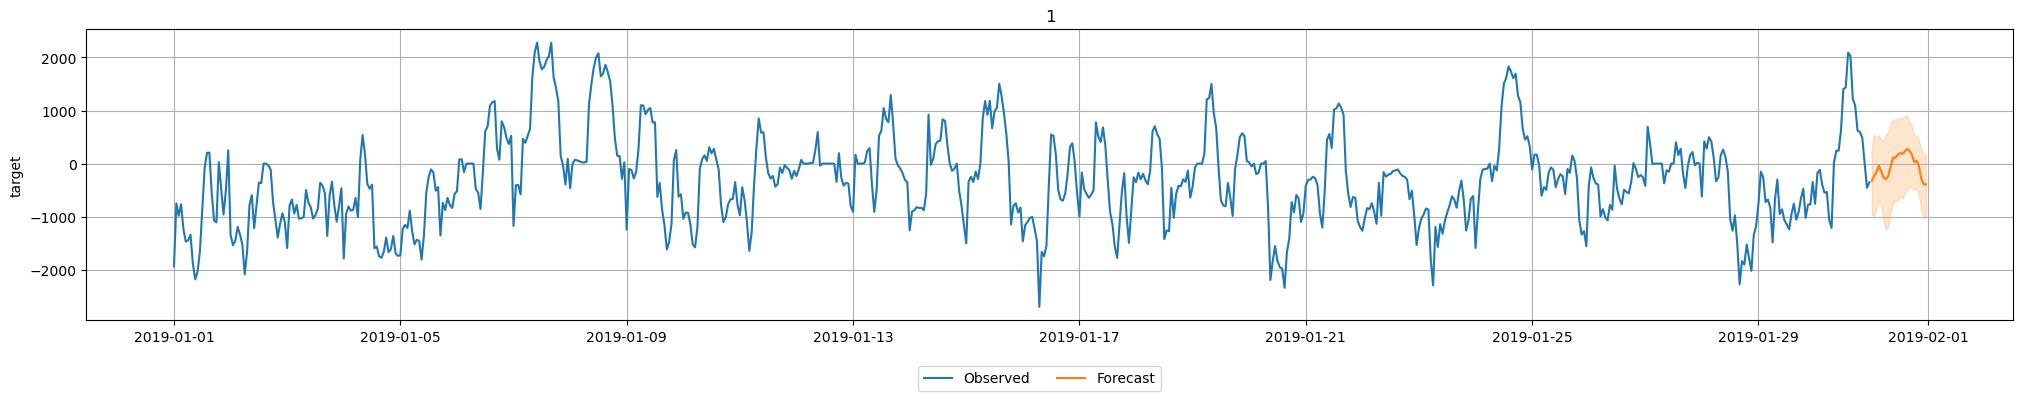

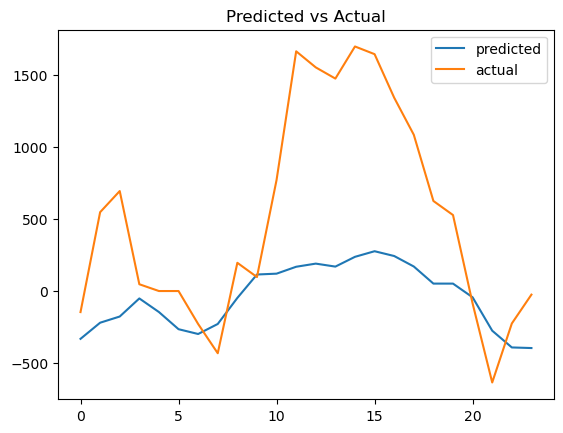

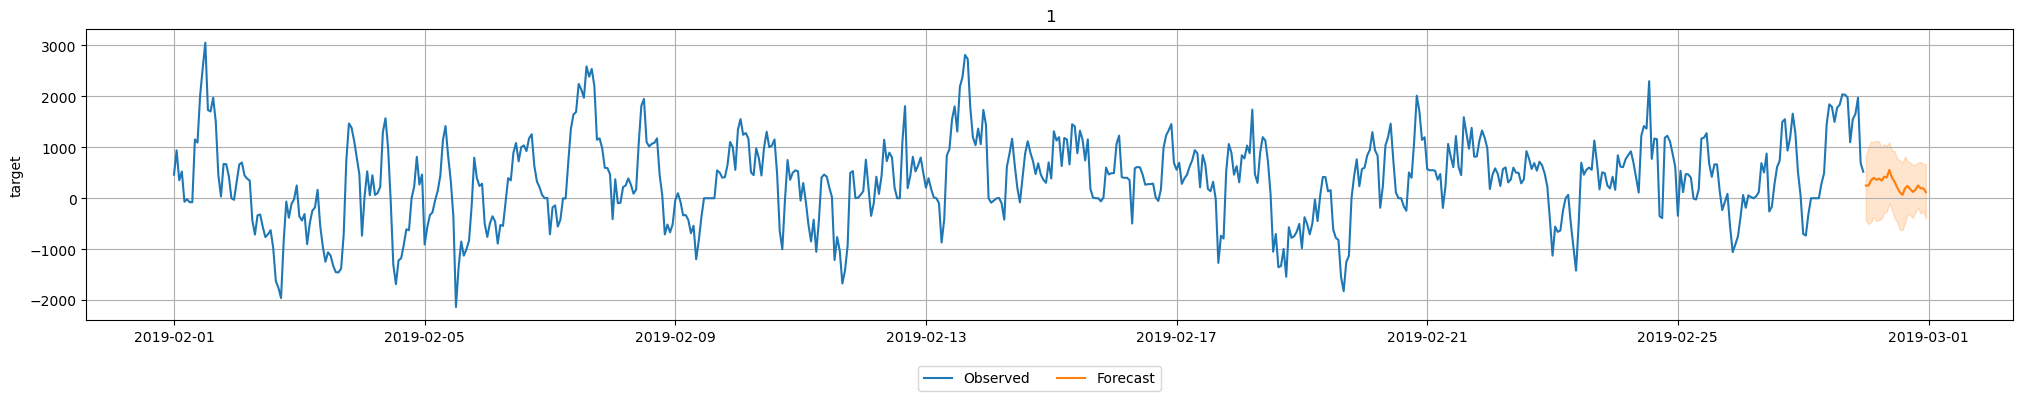

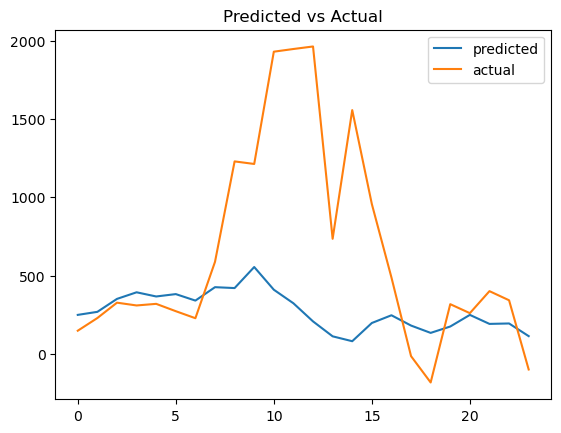

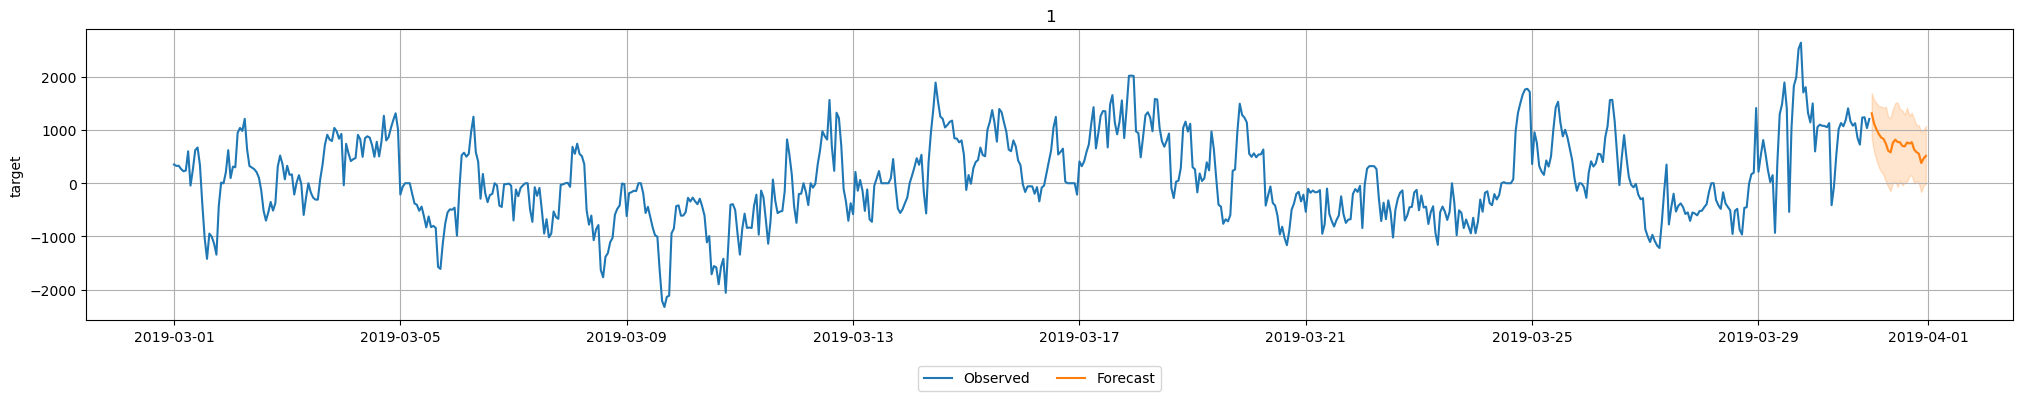

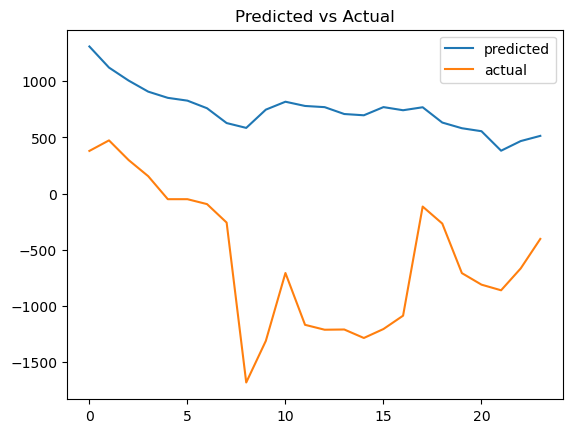

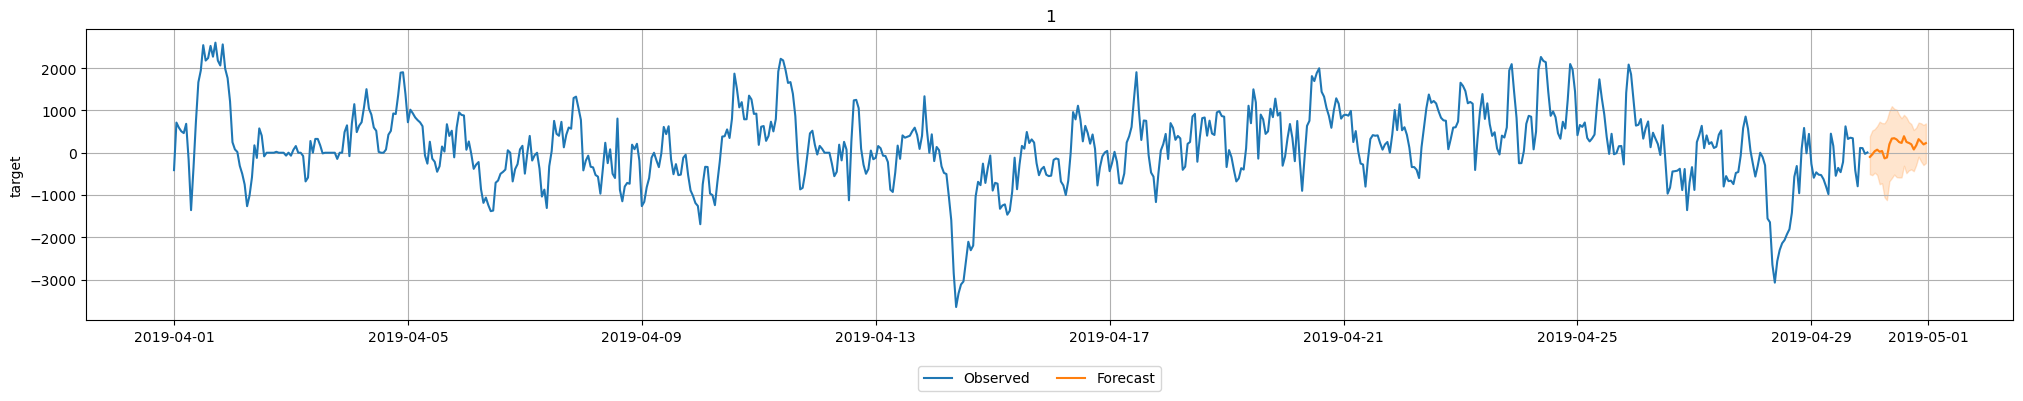

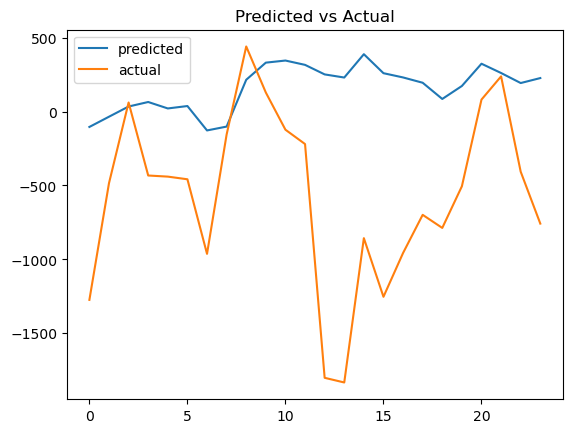

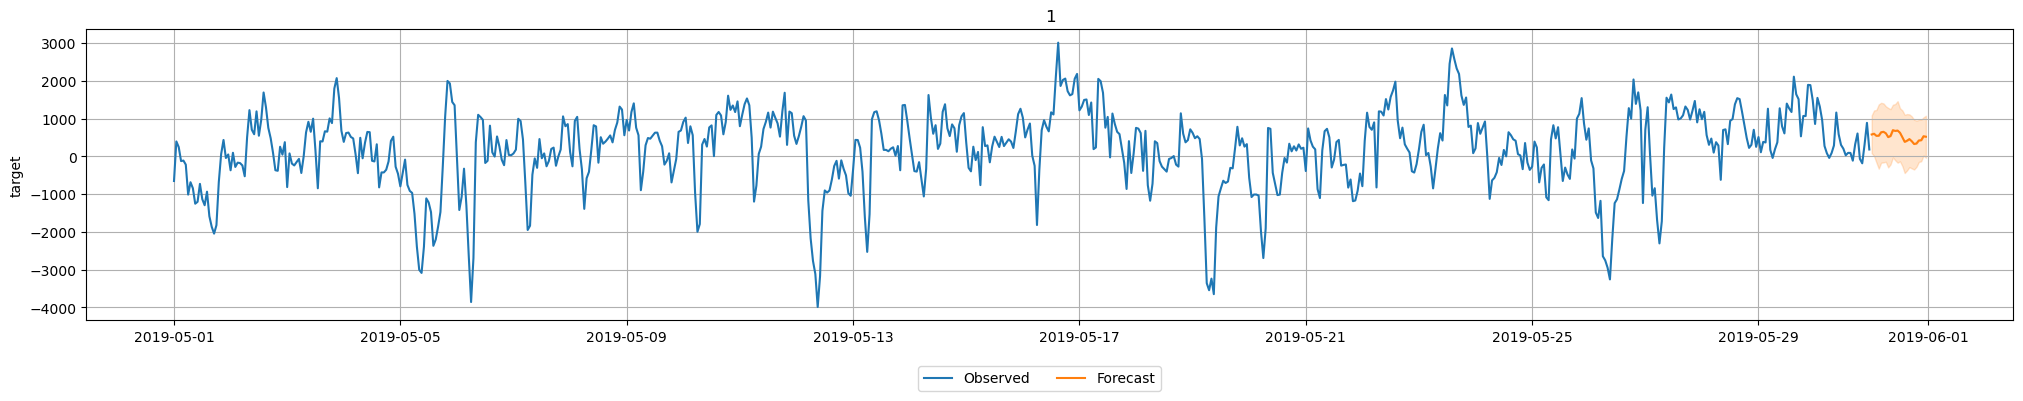

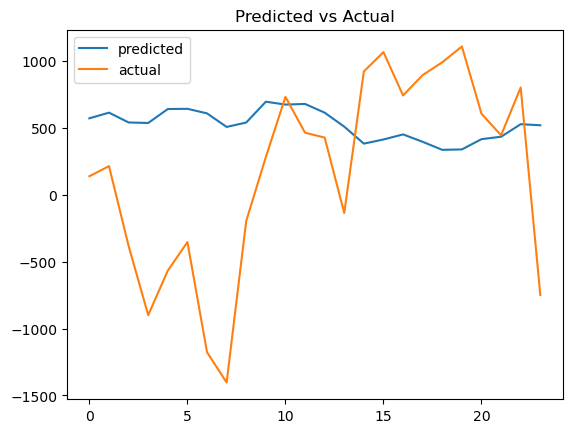

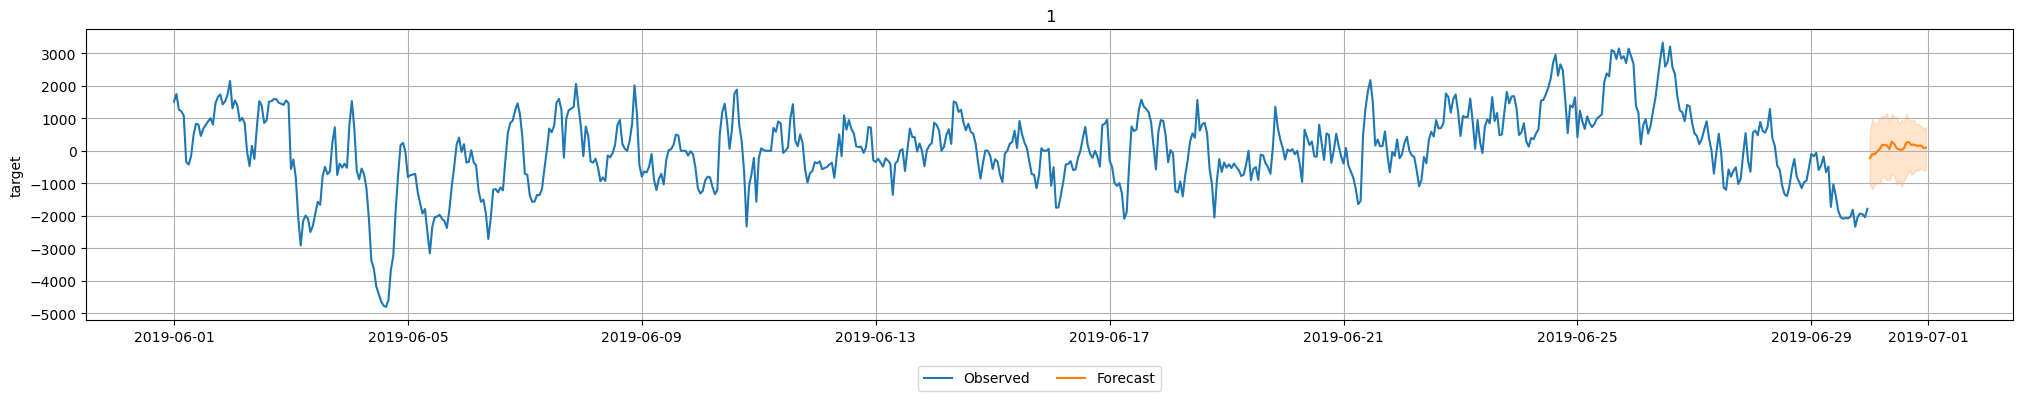

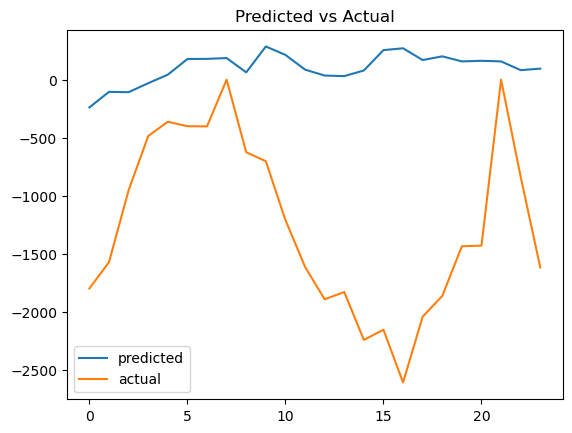

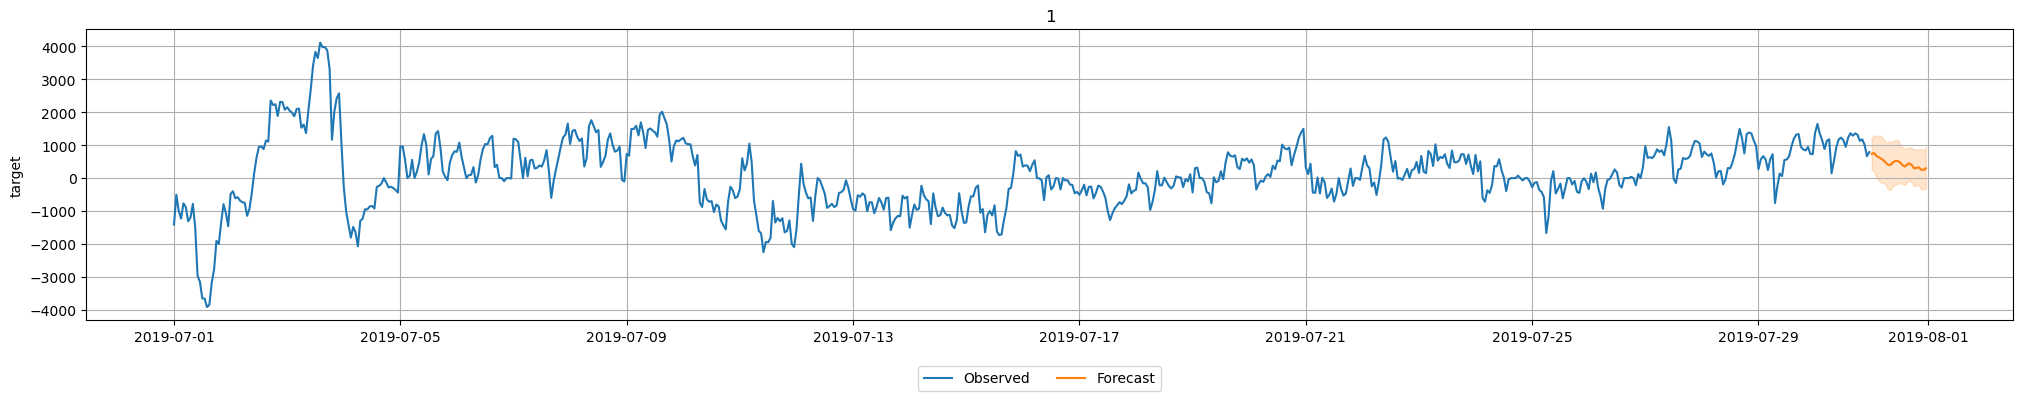

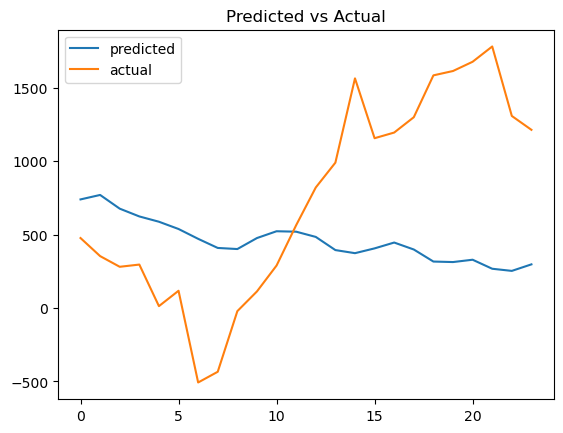

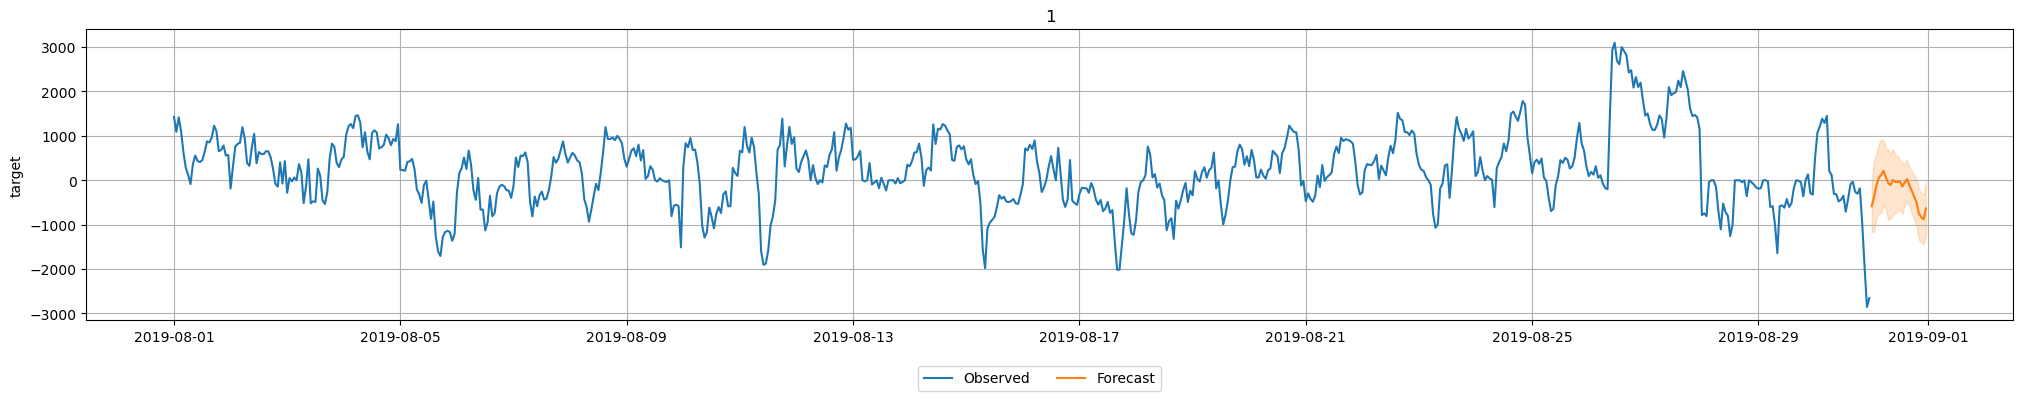

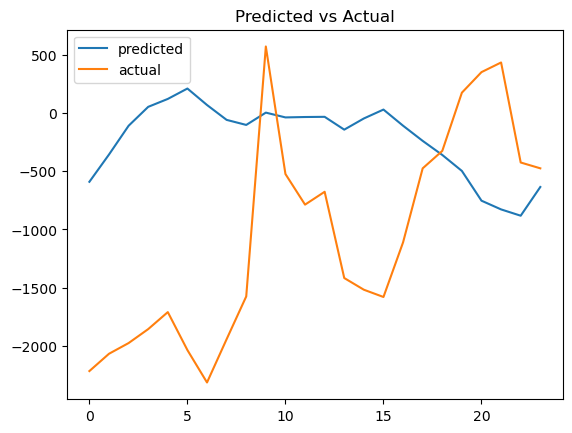

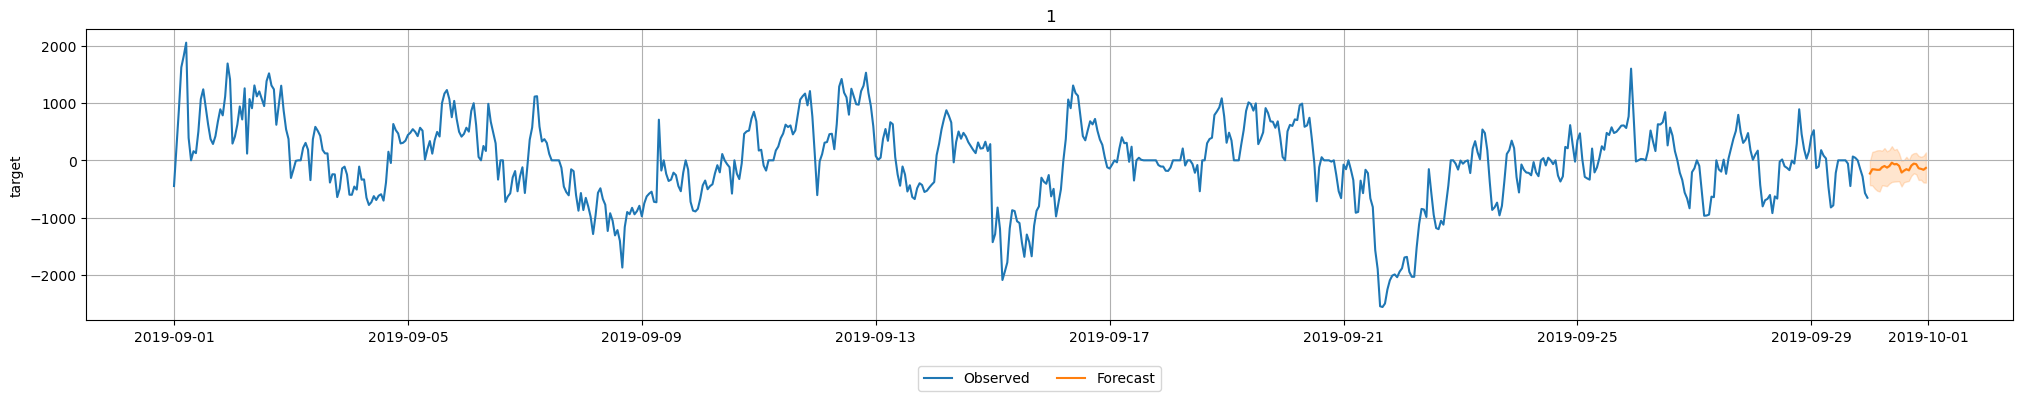

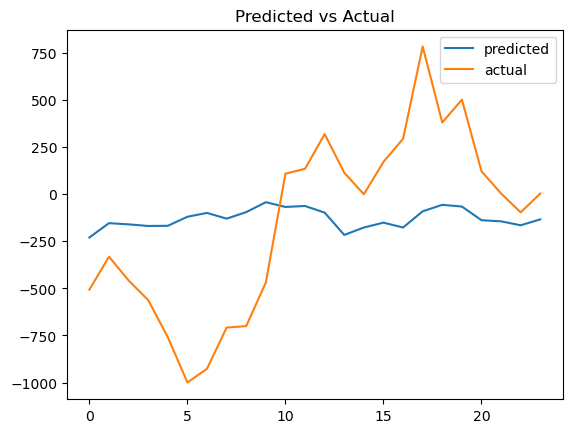

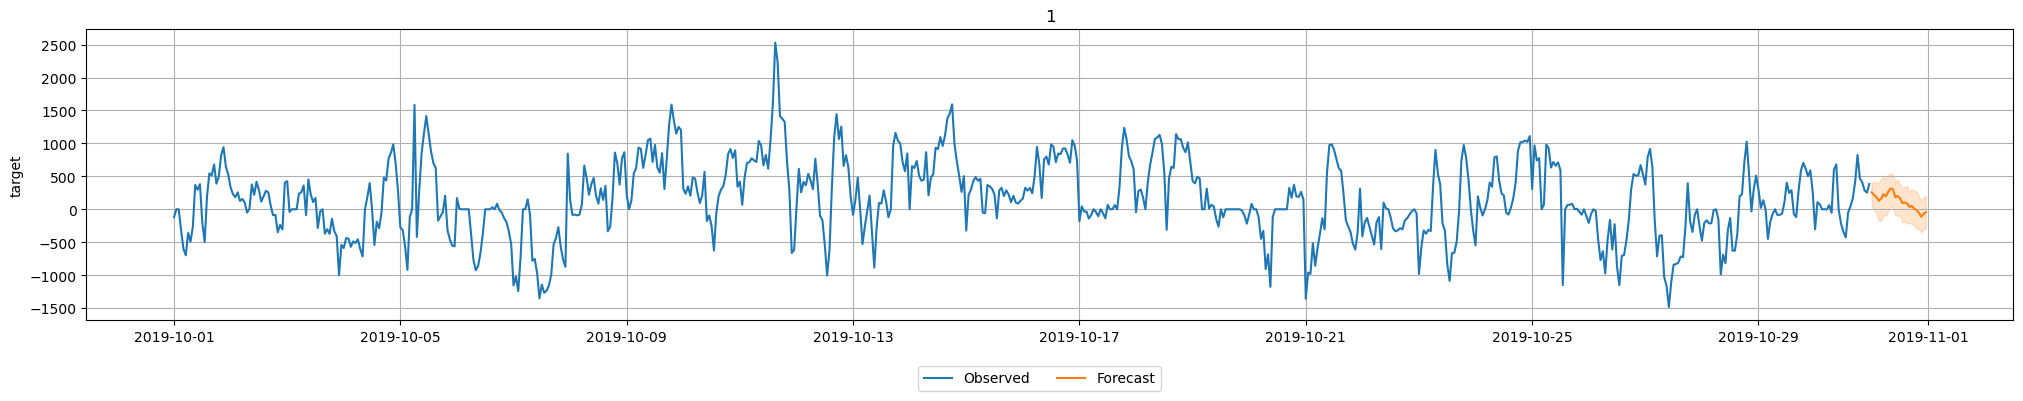

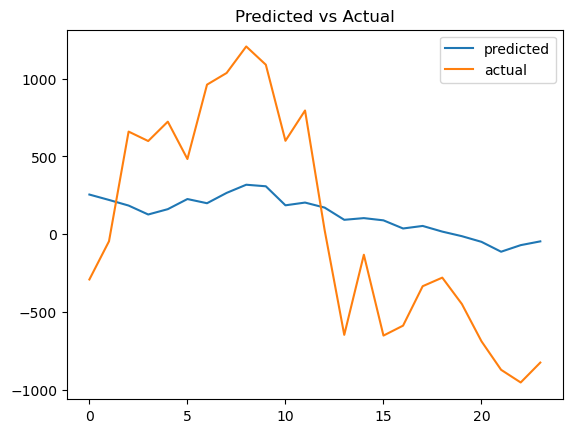

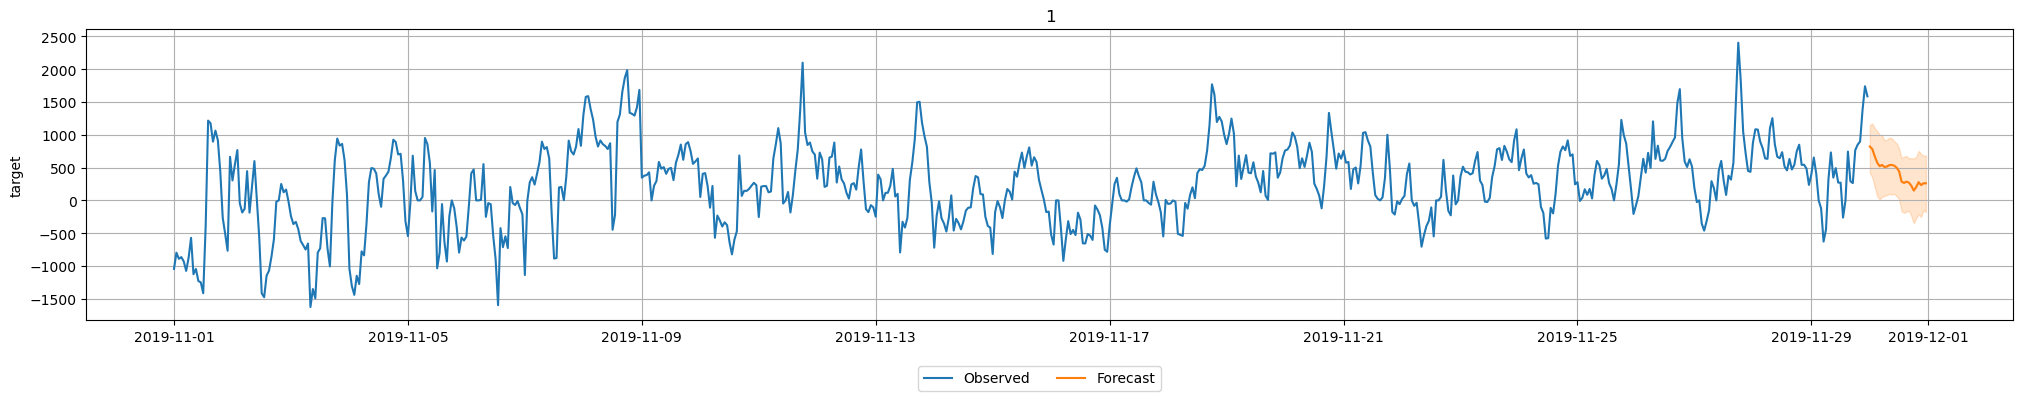

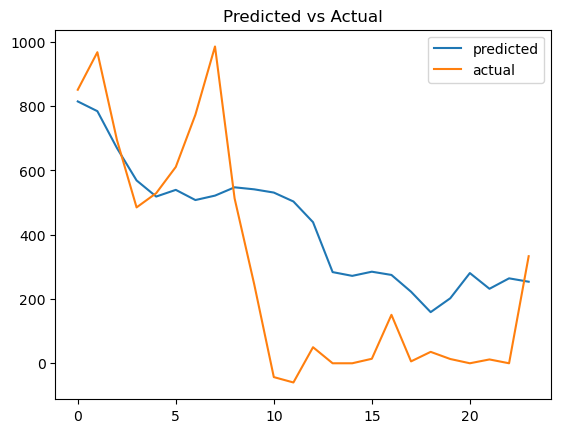

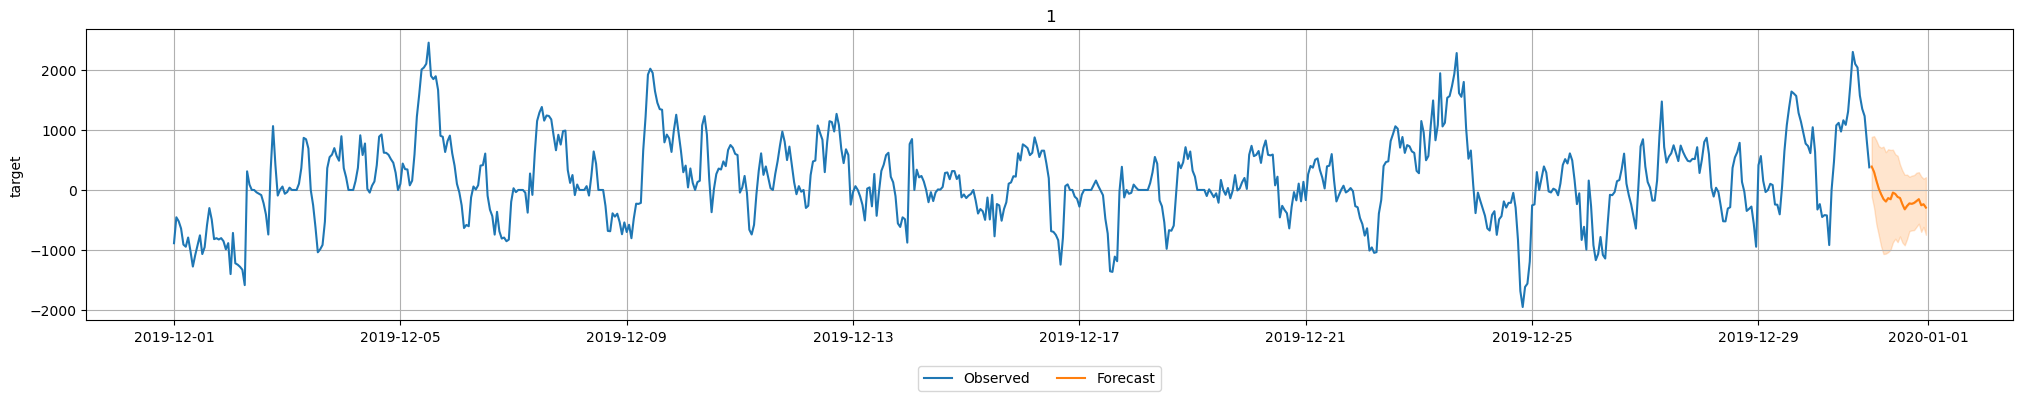

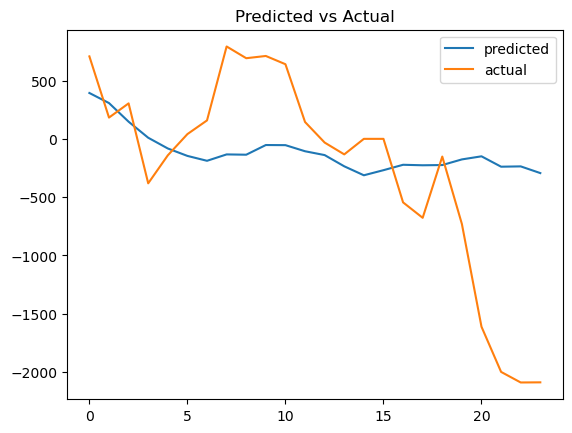

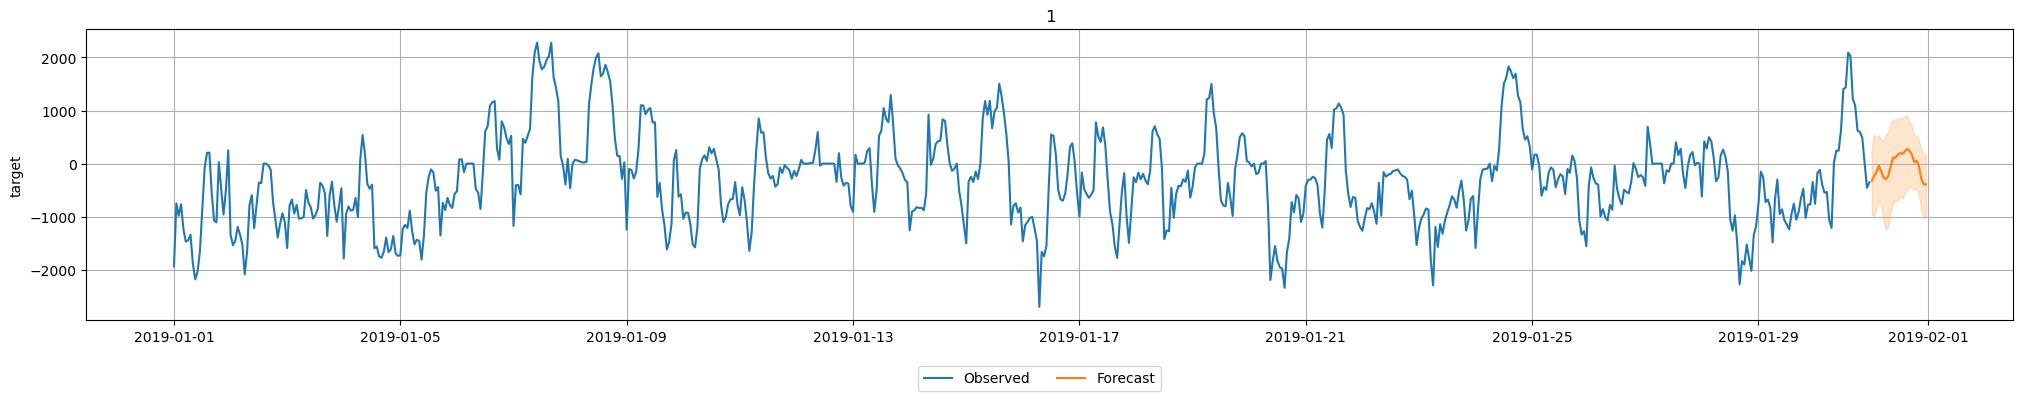

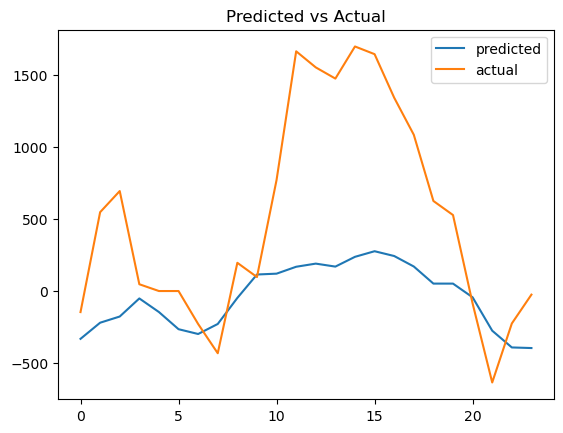

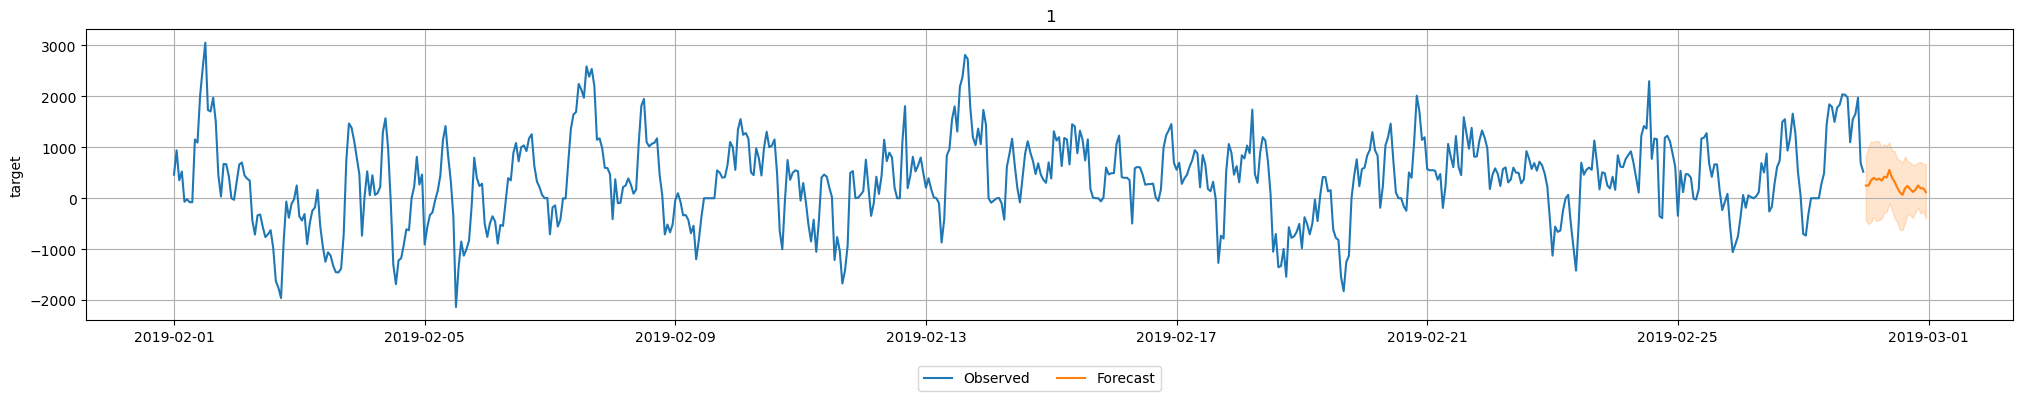

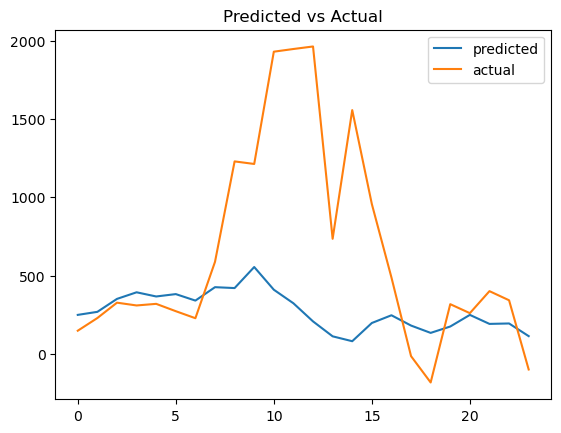

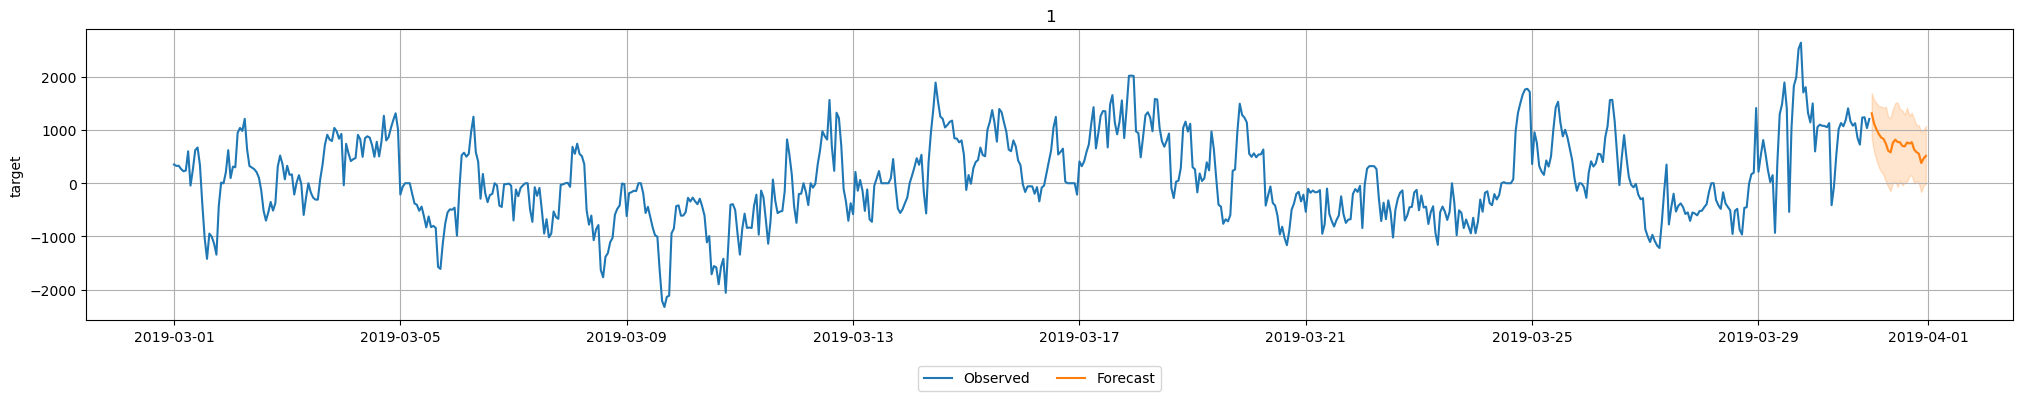

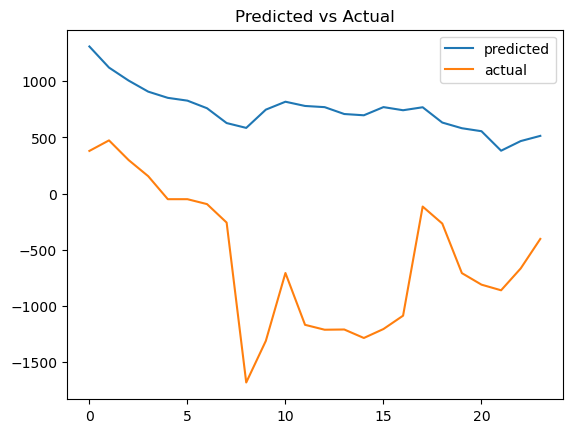

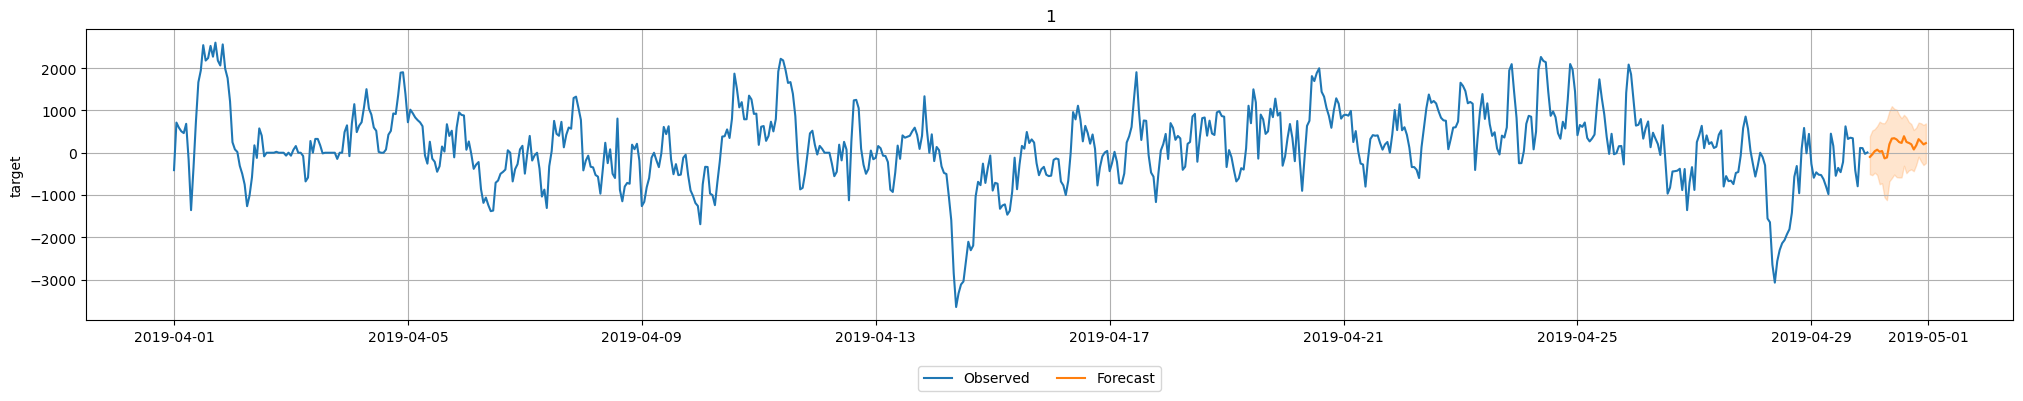

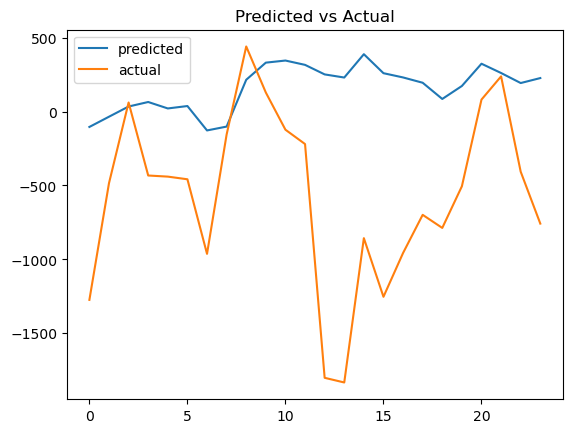

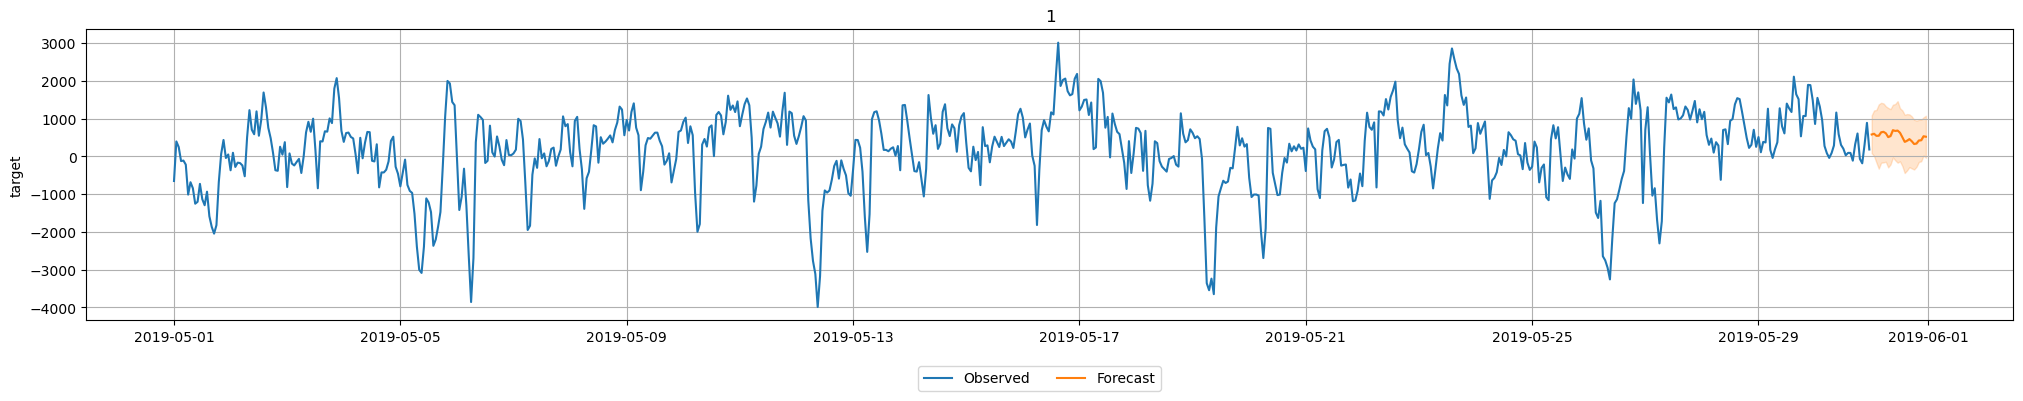

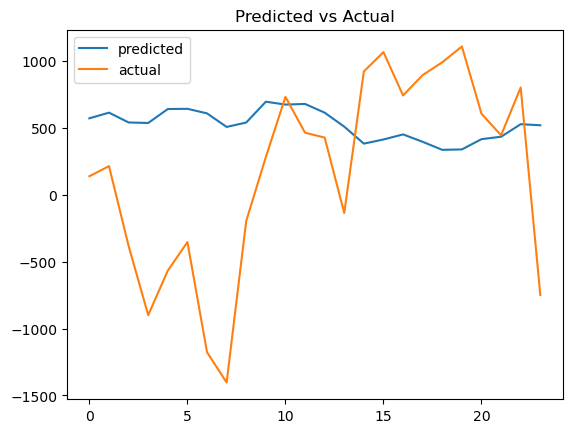

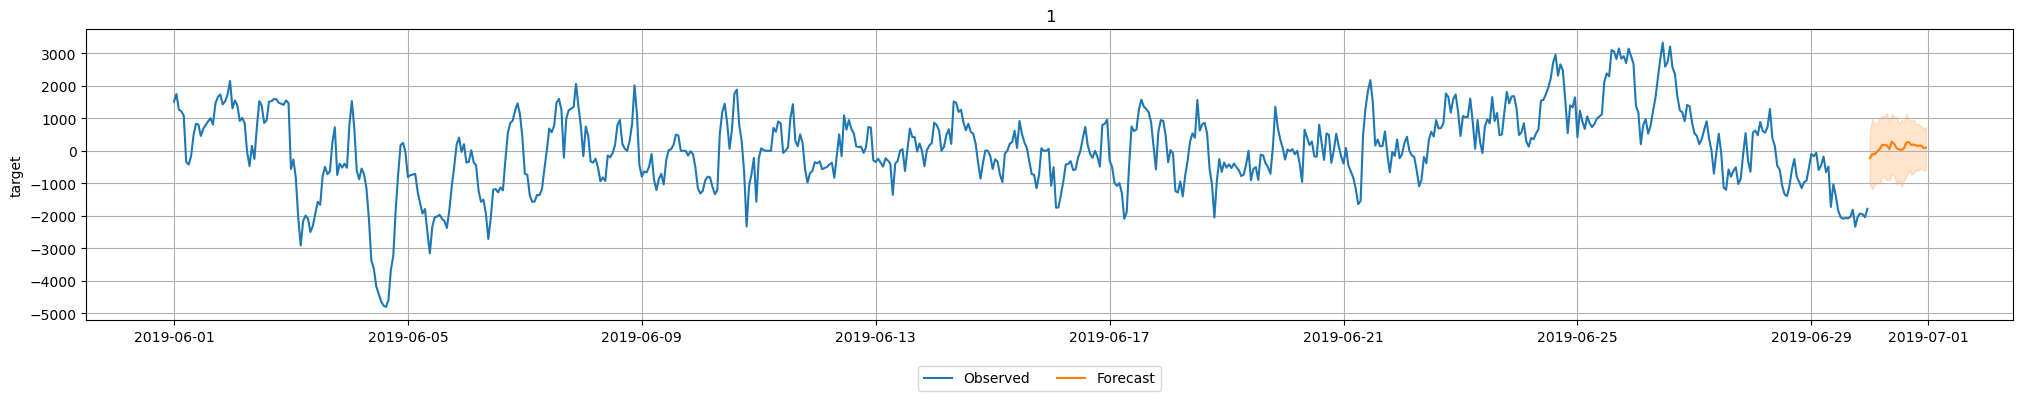

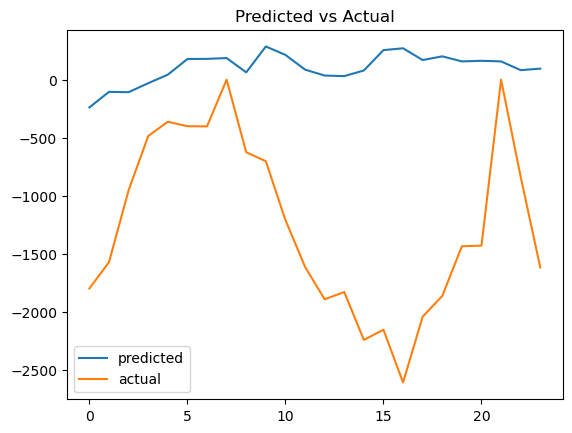

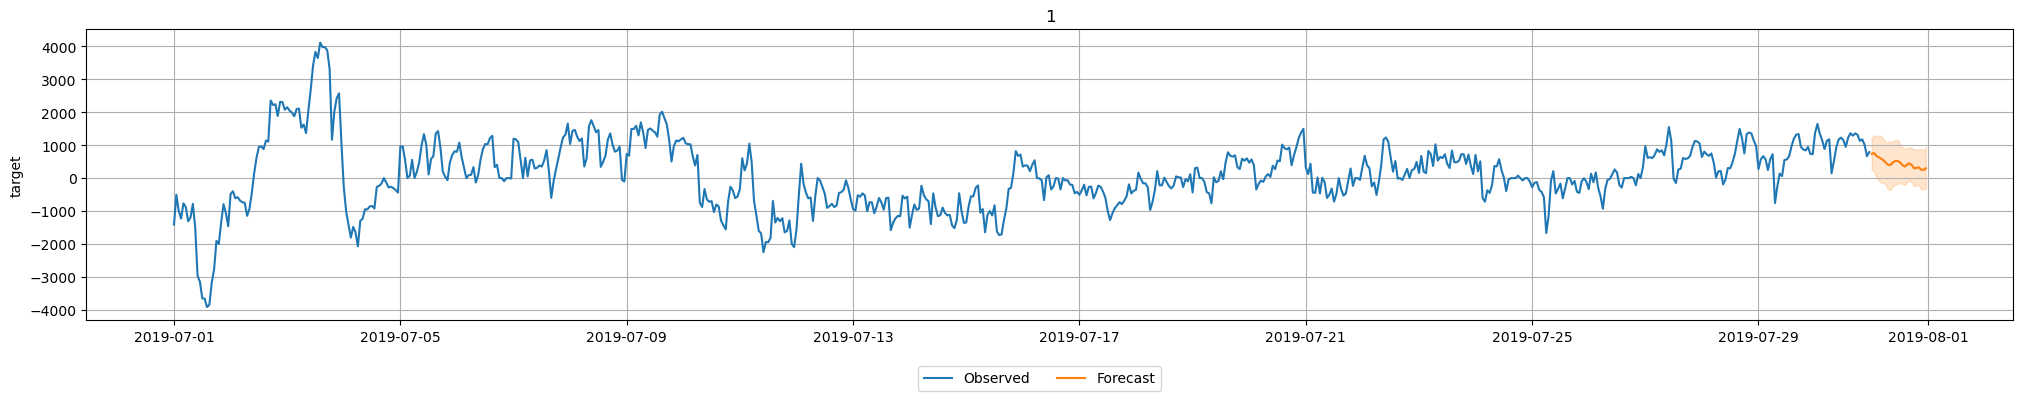

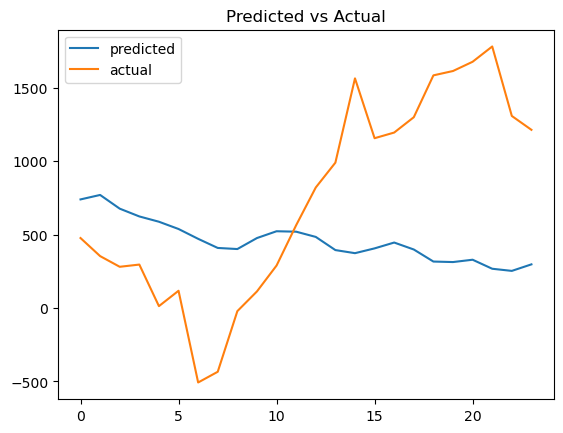

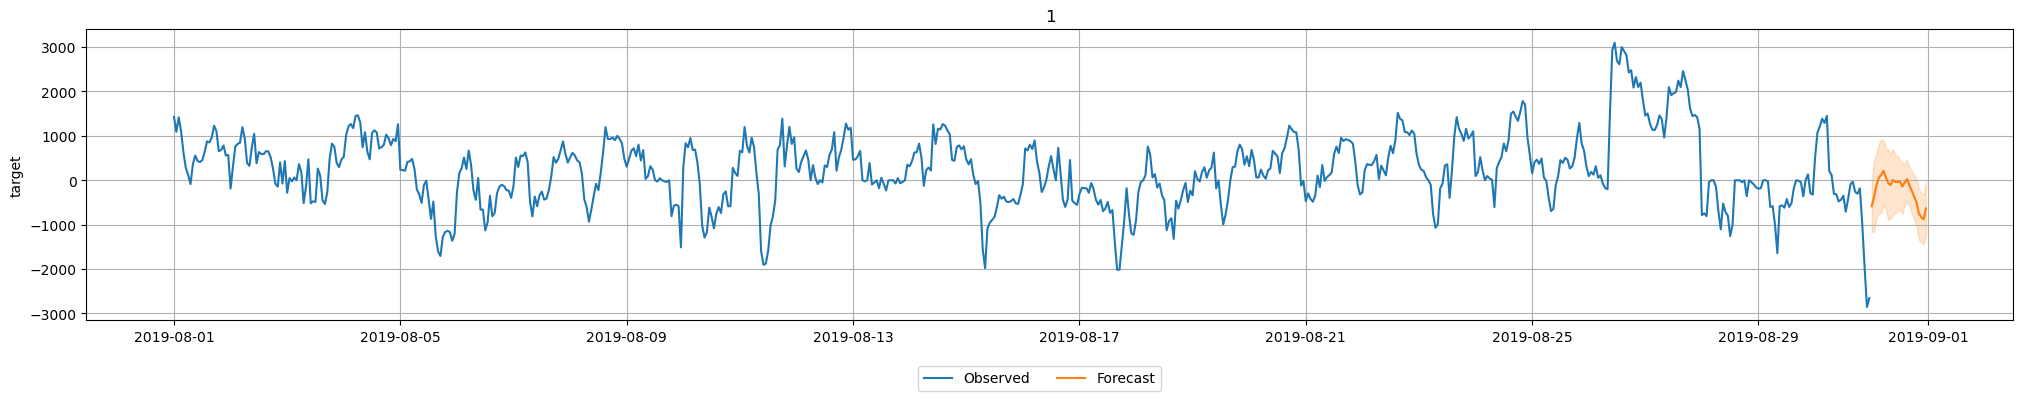

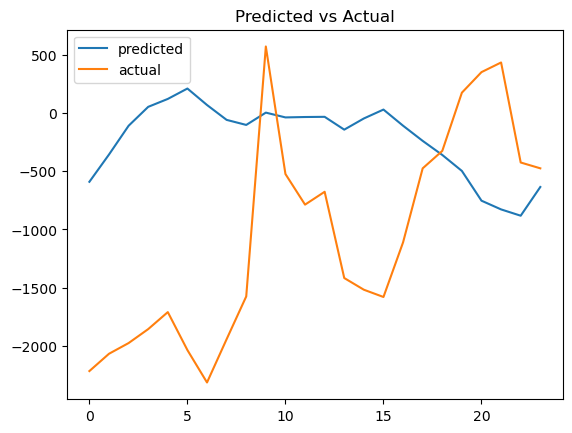

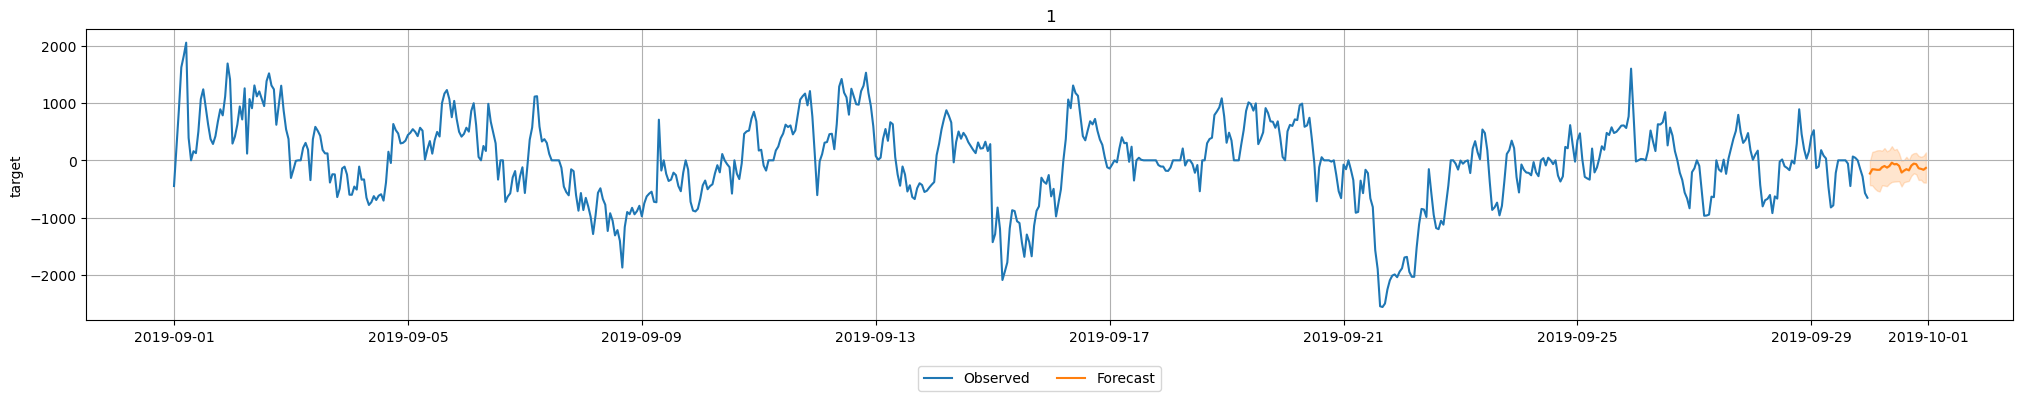

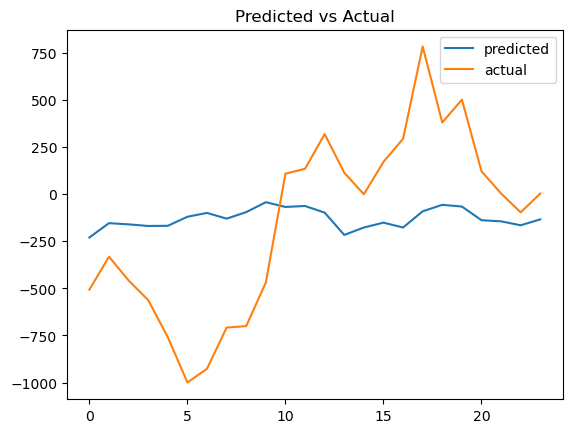

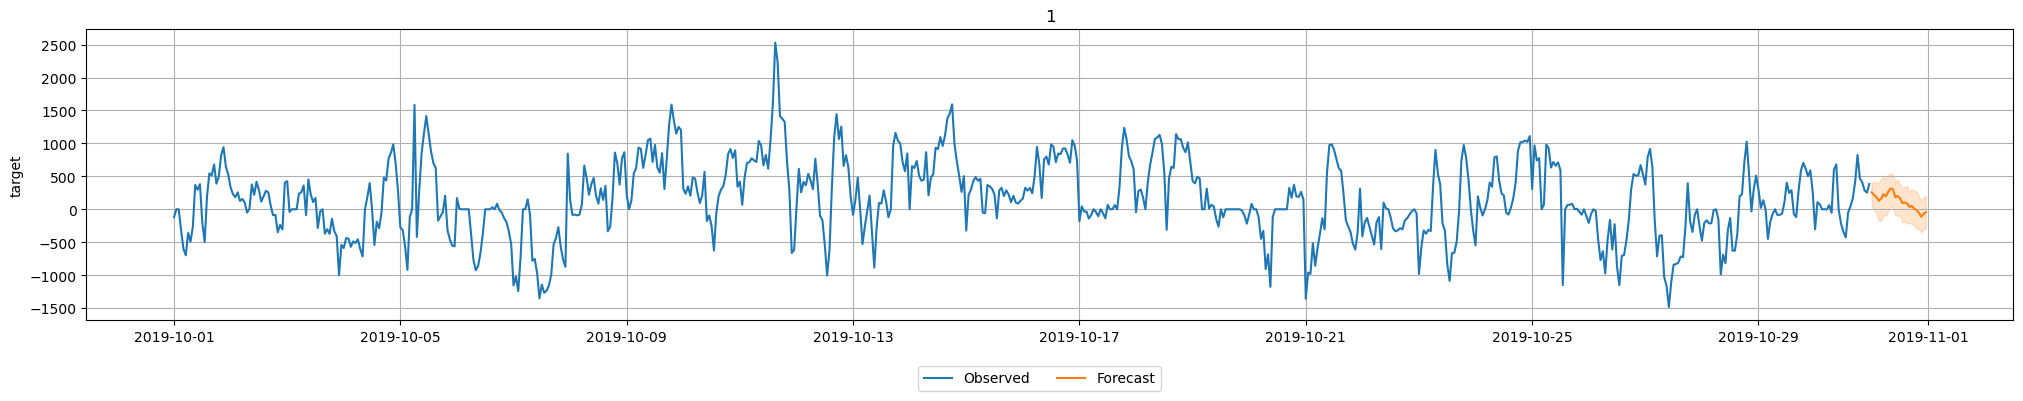

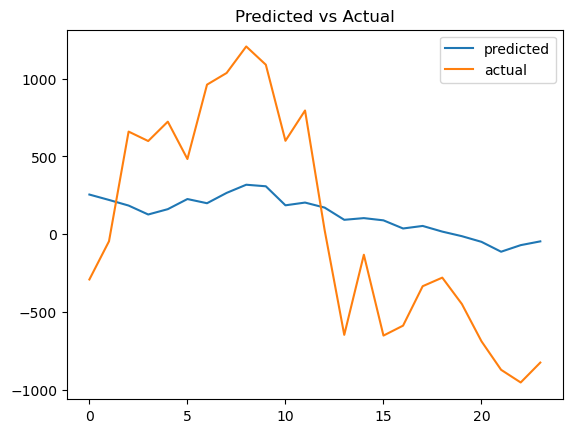

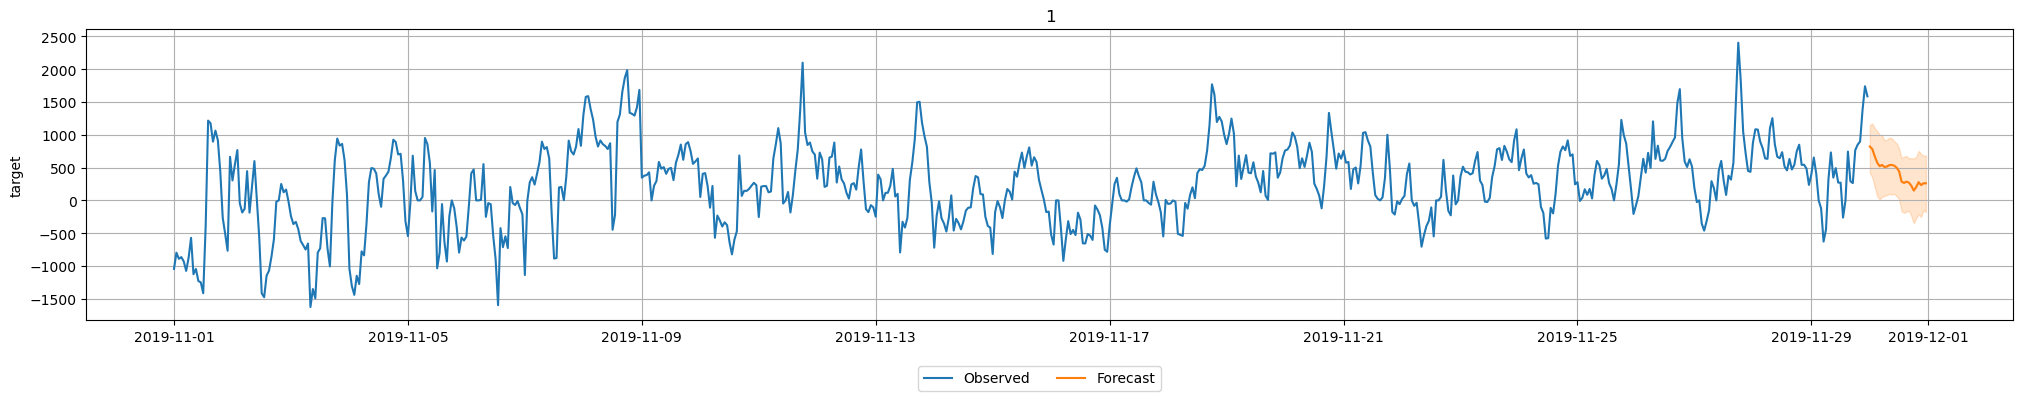

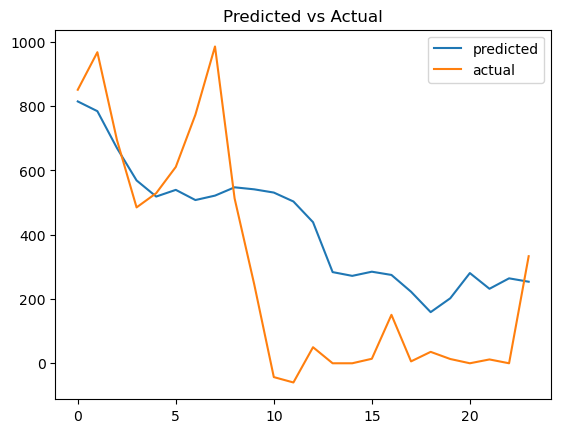

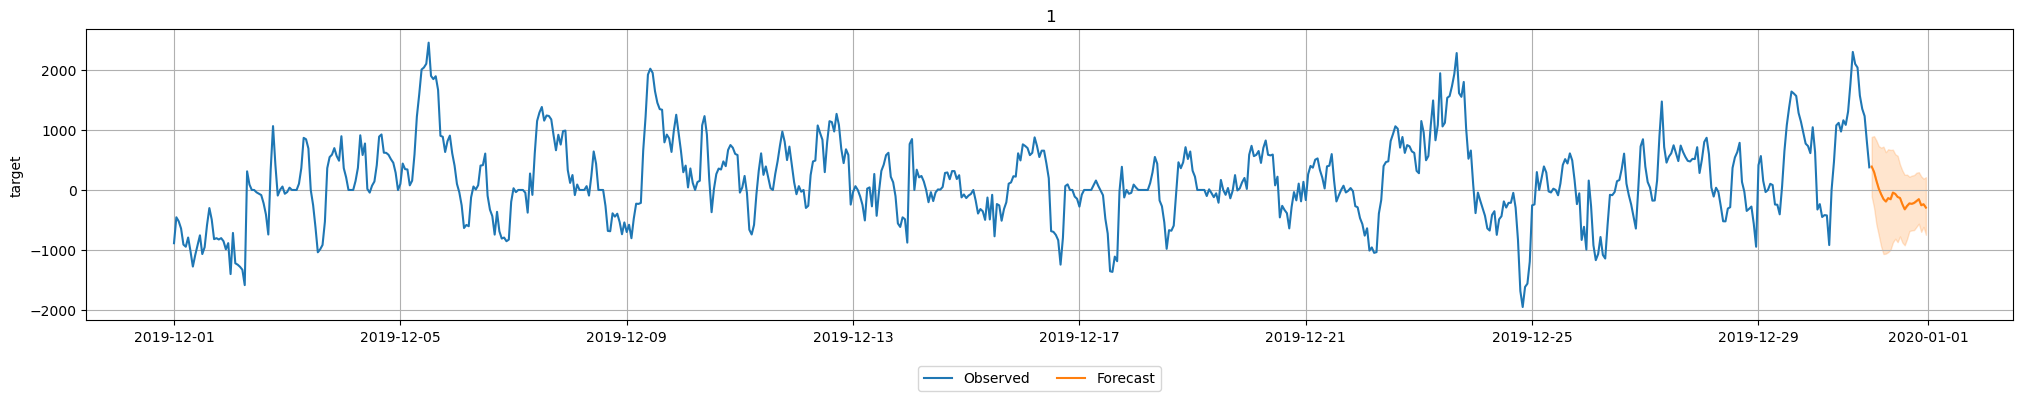

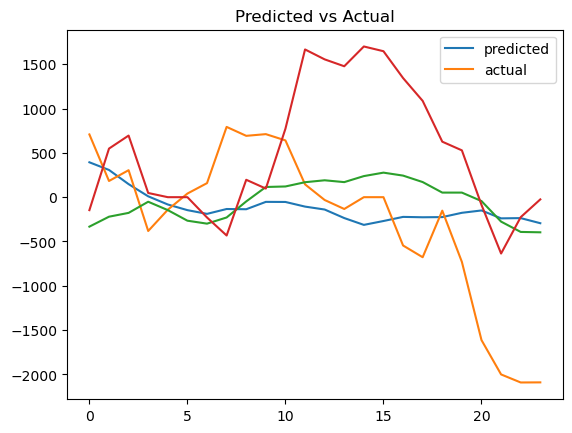

For  month_2
30.957053866685914 32.01854235597523
0     hold
1     hold
2     hold
3      buy
4      buy
5      buy
6      buy
7      buy
8      buy
9      buy
10     buy
11     buy
12     buy
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19     buy
20     buy
21     buy
22     buy
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0     hold
1     hold
2     hold
3      buy
4      buy
5      buy
6      buy
7      buy
8      buy
9      buy
10     buy
11     buy
12     buy
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19     buy
20     buy
21     buy
22     buy
23     buy
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 1
Incorrect predictions with volume: 0
Correct predictions without volume: 23
Correct predictions with volume: 24


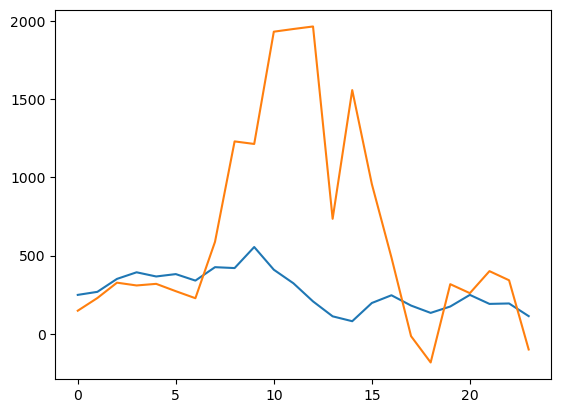

For  month_3
-103.01140934754397 3.1016552310618763
0      buy
1      buy
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0      buy
1      buy
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12     buy
13     buy
14    hold
15    hold
16    hold
17    hold
18     buy
19     buy
20     buy
21     buy
22     buy
23     buy
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 9
Incorrect predictions with volume: 7
Correct predictions without volume: 15
Correct predictions with volume: 17


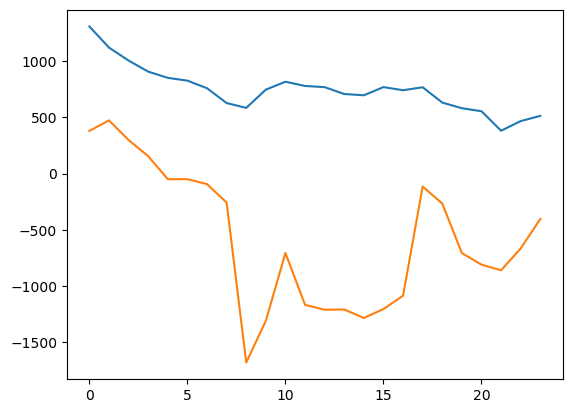

For  month_4
-87.61237632629066 7.532737565128528
0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8      buy
9      buy
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20     buy
21     buy
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8      buy
9      buy
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17     buy
18     buy
19     buy
20     buy
21     buy
22     buy
23    hold
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 4
Incorrect predictions with volume: 0
Correct predictions without volume: 20
Correct predictions with volume: 24


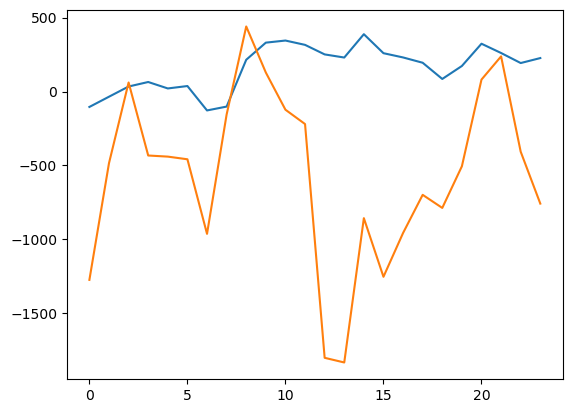

For  month_5
-139.40093131172418 26.77719761814476
0      buy
1      buy
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9      buy
10     buy
11     buy
12     buy
13    hold
14     buy
15     buy
16     buy
17     buy
18     buy
19     buy
20     buy
21    hold
22     buy
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0      buy
1      buy
2      buy
3      buy
4      buy
5      buy
6     hold
7      buy
8      buy
9      buy
10     buy
11     buy
12     buy
13     buy
14     buy
15     buy
16     buy
17     buy
18     buy
19     buy
20     buy
21    hold
22     buy
23     buy
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 8
Incorrect predictions with volume: 0
Correct predictions without volume: 16
Correct predictions with volume: 24


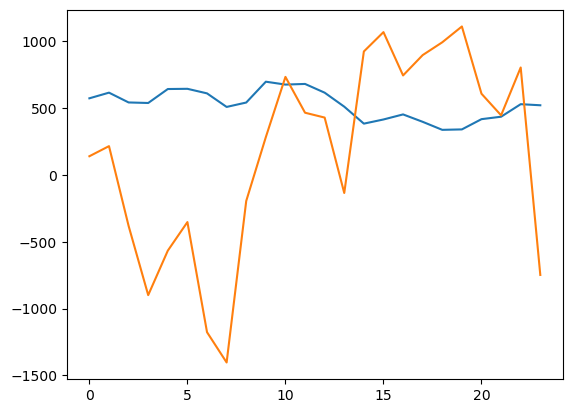

For  month_6
-325.73852697048073 3.4709559193294908
0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21     buy
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0     hold
1     hold
2     hold
3      buy
4      buy
5      buy
6     hold
7     hold
8     hold
9     hold
10     buy
11     buy
12     buy
13     buy
14     buy
15     buy
16     buy
17     buy
18     buy
19     buy
20     buy
21     buy
22     buy
23     buy
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 16
Incorrect predictions with volume: 0
Correct predictions without volume: 8
Correct predictions with volume: 24


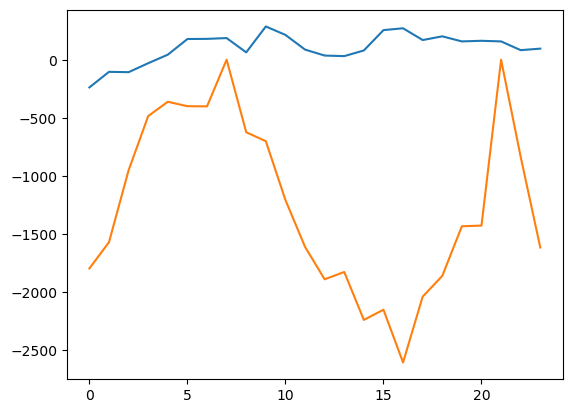

For  month_7
16.677575926950254 33.14703703820886
0      buy
1      buy
2      buy
3      buy
4      buy
5      buy
6     hold
7     hold
8      buy
9      buy
10     buy
11     buy
12     buy
13     buy
14     buy
15     buy
16     buy
17    hold
18     buy
19     buy
20     buy
21    hold
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0      buy
1      buy
2      buy
3      buy
4      buy
5      buy
6      buy
7      buy
8      buy
9      buy
10     buy
11     buy
12     buy
13     buy
14     buy
15     buy
16     buy
17    hold
18     buy
19     buy
20     buy
21    hold
22    hold
23    hold
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 2
Incorrect predictions with volume: 0
Correct predictions without volume: 22
Correct predictions with volume: 24


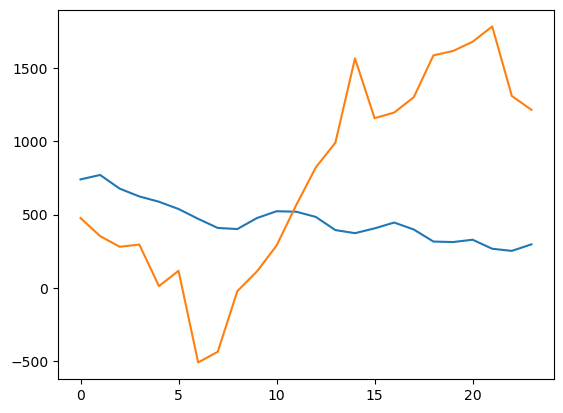

For  month_8
-17.77165105963529 1.029745361453692
0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19     buy
20     buy
21    hold
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15     buy
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 3
Incorrect predictions with volume: 0
Correct predictions without volume: 21
Correct predictions with volume: 24


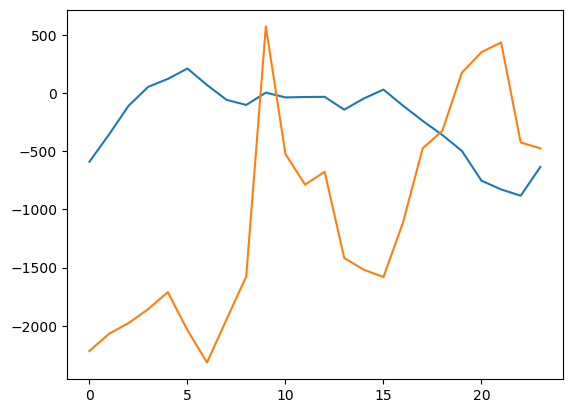

For  month_9
0 0
0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0
Correct predictions without volume: 24
Correct predictions with volume: 24


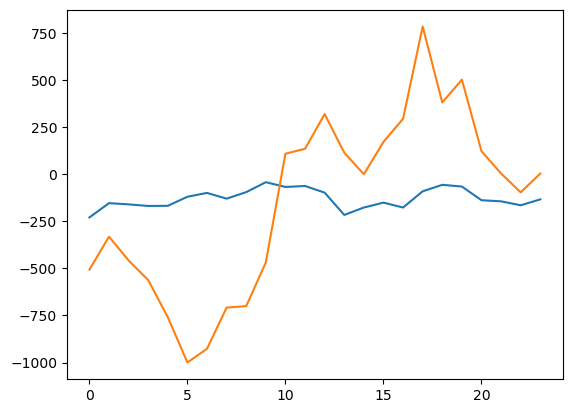

For  month_10
-4.32336634918336 0
0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0      buy
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 1
Incorrect predictions with volume: 0
Correct predictions without volume: 23
Correct predictions with volume: 24


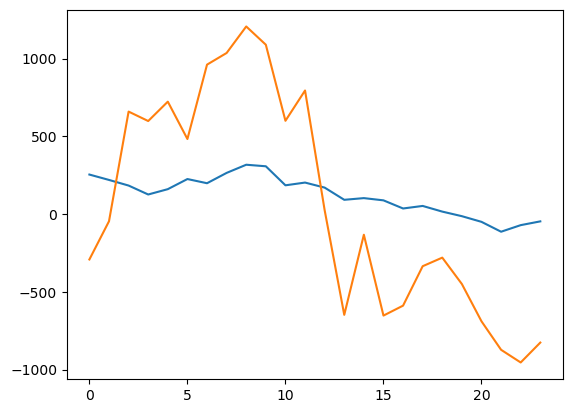

For  month_11
0 0
0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0
Correct predictions without volume: 24
Correct predictions with volume: 24


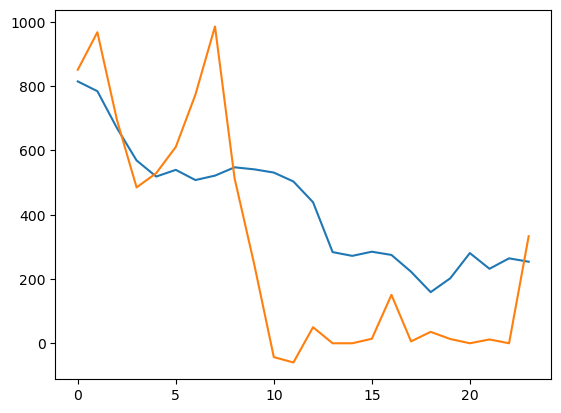

For  month_12
0 0
0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithVolume, dtype: object 0     hold
1     hold
2     hold
3     hold
4     hold
5     hold
6     hold
7     hold
8     hold
9     hold
10    hold
11    hold
12    hold
13    hold
14    hold
15    hold
16    hold
17    hold
18    hold
19    hold
20    hold
21    hold
22    hold
23    hold
Name: tradeSuggestionWithoutVolume, dtype: object
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0
Correct predictions without volume: 24
Correct predictions with volume: 24


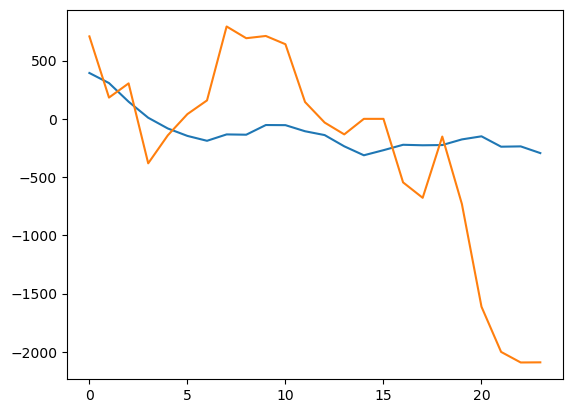

Total profit with volume:  107.07787108930243
Total profit without volume:  -630.2236315712221
Success rate with volume:  0.9756944444444445
Success rate without volume:  0.8472222222222223


In [163]:
from matplotlib import pyplot as plt

total_profit_with_volume = 0
total_profit_without_volume = 0
success_rate_with_volume = 0
success_rate_without_volume = 0
for key, value in monthly_comparison_results.items():
    print("For ", key)
    print(value["pnlWithoutVolume"].sum(), value["pnlWithVolume"].sum())
    print(value["tradeSuggestionWithVolume"], value["tradeSuggestionWithoutVolume"])
    value["tradeSuggestionWithoutVolume"] = value["tradeSuggestionWithoutVolume"].apply(
        lambda x: 1 if x == "buy" else 0
    )

    value["tradeSuggestionWithVolume"] = value["tradeSuggestionWithVolume"].apply(
        lambda x: 1 if x == "buy" else 0
    )


    incorrect_predictions_without_volume = value[
        value["tradeSuggestionWithoutVolume"] != value["is_long_profitable"]
    ]
    incorrect_predictions_with_volume = value[
        value["tradeSuggestionWithVolume"] != value["is_long_profitable"]
    ]
    
    print(
        f"Incorrect predictions without volume: {len(incorrect_predictions_without_volume)}"
    )
    print(
        f"Incorrect predictions with volume: {len(incorrect_predictions_with_volume)}"
    )

    correct_predictions_without_volume = value[
        value["tradeSuggestionWithoutVolume"] == value["is_long_profitable"]
    ]
    correct_predictions_with_volume = value[
        value["tradeSuggestionWithVolume"] == value["is_long_profitable"]
    ]
    print(
        f"Correct predictions without volume: {len(correct_predictions_without_volume)}"
    )
    print(f"Correct predictions with volume: {len(correct_predictions_with_volume)}")
    plt.plot(value["netImbalanceVolumePredicted"])
    plt.plot(value["netImbalanceVolumeActual"])
    plt.show()
    total_profit_with_volume += value["pnlWithVolume"].sum()
    total_profit_without_volume += value["pnlWithoutVolume"].sum()
    success_rate_with_volume += len(correct_predictions_with_volume) / len(value)
    success_rate_without_volume += len(correct_predictions_without_volume) / len(value)


print("Total profit with volume: ", total_profit_with_volume)
print("Total profit without volume: ", total_profit_without_volume)
print("Success rate with volume: ", success_rate_with_volume / 12)
print("Success rate without volume: ", success_rate_without_volume / 12)

In [164]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
profits = {}
for threshold in thresholds:
    profits[threshold] = {
        "profitWithVolume": 0,
        "profitWithoutVolume": 0,
        "accuracyWithVolume": 0,
        "accuracyWithoutVolume": 0,
    }
for key, value in monthly_comparison_results.items():

    print("For ", key)
    for threshold in thresholds:

        print(f"Threshold: {threshold}")
        value["tradeSuggestionWithoutVolume"] = value[
            "longOpportunityProbaWithoutVolume"
        ].apply(lambda x: 1 if x > threshold else 0)
        value["tradeSuggestionWithVolume"] = value[
            "longOpportunityProbaWithVolume"
        ].apply(lambda x: 1 if x > threshold else 0)

        incorrect_predictions_without_volume = value[
            value["tradeSuggestionWithoutVolume"] != value["is_long_profitable"]
        ]

        incorrect_predictions_with_volume = value[
            value["tradeSuggestionWithVolume"] != value["is_long_profitable"]
        ]

        print(
            f"Incorrect predictions without volume: {len(incorrect_predictions_without_volume)}"
        )

        print(
            f"Incorrect predictions with volume: {len(incorrect_predictions_with_volume)}"
        )

        correct_predictions_without_volume = value[
            value["tradeSuggestionWithoutVolume"] == value["is_long_profitable"]
        ]

        correct_predictions_with_volume = value[
            value["tradeSuggestionWithVolume"] == value["is_long_profitable"]
        ]

        print(
            f"Correct predictions without volume: {len(correct_predictions_without_volume)}"
        )

        print(
            f"Correct predictions with volume: {len(correct_predictions_with_volume)}"
        )

        value["tradeSuggestionWithoutVolume"] = value[
            "longOpportunityProbaWithoutVolume"
        ].apply(lambda x: "buy" if x > threshold else "hold")
        value["tradeSuggestionWithVolume"] = value[
            "longOpportunityProbaWithVolume"
        ].apply(lambda x: "buy" if x > threshold else "hold")

        value["pnlWithoutVolume"] = value.apply(
            lambda row: calculate_pnl(
                row["mcpUsd"],
                row["smpUsd"],
                row["idmUsd"],
                row["tradeSuggestionWithoutVolume"],
            ),
            axis=1,
        )

        value["pnlWithVolume"] = value.apply(
            lambda row: calculate_pnl(
                row["mcpUsd"],
                row["smpUsd"],
                row["idmUsd"],
                row["tradeSuggestionWithVolume"],
            ),
            axis=1,
        )

        print("Profit without volume: ", value["pnlWithoutVolume"].sum())
        print("Profit with volume: ", value["pnlWithVolume"].sum())
        
        profits[threshold]["profitWithVolume"] += value["pnlWithVolume"].sum()
        profits[threshold]["profitWithoutVolume"] += value["pnlWithoutVolume"].sum()
        profits[threshold]["accuracyWithVolume"] += len(correct_predictions_with_volume) / len(value)
        profits[threshold]["accuracyWithoutVolume"] += len(correct_predictions_without_volume) / len(value)
    profits[threshold]["accuracyWithVolume"] += len(correct_predictions_with_volume) / len(value)
    profits[threshold]["accuracyWithoutVolume"] += len(correct_predictions_without_volume) / len(value)

For  month_1
Threshold: 0.5
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0


Correct predictions without volume: 24
Correct predictions with volume: 24
Profit without volume:  0
Profit with volume:  0
Threshold: 0.6
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0
Correct predictions without volume: 24
Correct predictions with volume: 24
Profit without volume:  0
Profit with volume:  0
Threshold: 0.7
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0
Correct predictions without volume: 24
Correct predictions with volume: 24
Profit without volume:  0
Profit with volume:  0
Threshold: 0.8
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0
Correct predictions without volume: 24
Correct predictions with volume: 24
Profit without volume:  0
Profit with volume:  0
Threshold: 0.9
Incorrect predictions without volume: 0
Incorrect predictions with volume: 0
Correct predictions without volume: 24
Correct predictions with volume: 24
Profit without volume:  0
Profit with volume:  0
For  month_2

In [165]:
profits

{0.5: {'profitWithVolume': 107.07787108930243,
  'profitWithoutVolume': -630.2236315712221,
  'accuracyWithVolume': 11.708333333333334,
  'accuracyWithoutVolume': 10.166666666666668},
 0.6: {'profitWithVolume': 107.07787108930243,
  'profitWithoutVolume': -630.2236315712221,
  'accuracyWithVolume': 11.708333333333334,
  'accuracyWithoutVolume': 10.166666666666668},
 0.7: {'profitWithVolume': 107.07787108930243,
  'profitWithoutVolume': -587.1328848058016,
  'accuracyWithVolume': 11.708333333333334,
  'accuracyWithoutVolume': 10.291666666666668},
 0.8: {'profitWithVolume': 104.81679099149558,
  'profitWithoutVolume': -566.1403492563443,
  'accuracyWithVolume': 11.541666666666668,
  'accuracyWithoutVolume': 10.375},
 0.9: {'profitWithVolume': 104.2107225535651,
  'profitWithoutVolume': -497.44819288969205,
  'accuracyWithVolume': 22.916666666666664,
  'accuracyWithoutVolume': 20.666666666666664}}